In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd
import os

In [15]:
# load data
from scipy.io import loadmat

# sampling frequency from paper
fs = 2000
ninapro_root = "./Ninapro/DB1"
print(os.path.abspath(ninapro_root))



all_emg = {}
all_data = {}
for filename in os.listdir(ninapro_root):
    if filename.endswith("A1_E1.mat"):
        full_path = os.path.join(ninapro_root, filename)

        subject_id = filename.split("_")[0]  # "S1", "S2", ...

        mat = loadmat(full_path)
        emg = mat["emg"]
        all_data[subject_id] = mat
        all_emg[subject_id] = emg

print(all_emg.keys())
print(all_data['S1'].keys())

# dictionary with all subject emgs

/data/Ninapro/DB1
dict_keys(['S2', 'S1', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27'])
dict_keys(['__header__', '__version__', '__globals__', 'emg', 'stimulus', 'glove', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'])


## 1) Visualization and Preprocessing

In [16]:
# faire comme Part1 mais pour tous les subjects, à mon avis faudra virer des channels
# y'en aura forcément qui sont pas bien


all_processed = {}

for subject in all_data.keys():

    data = all_data[subject]

    # Extract variables for this subject
    emg_rectified = data["emg"].copy()
    stimulus = data["restimulus"].squeeze()
    repetition = data["rerepetition"].squeeze()

    # Store them
    all_processed[subject] = {
        "emg": emg_rectified,
        "stimulus": stimulus,
        "repetition": repetition
    }

    # Print basic info for this subject
    print(f"Subject: {subject}")
    print(f"  EMG shape:        {emg_rectified.shape}")
    print(f"  Stimulus shape:   {stimulus.shape}")
    print(f"  Repetition shape: {repetition.shape}")
    print("-" * 40)



Subject: S2
  EMG shape:        (100686, 10)
  Stimulus shape:   (100686,)
  Repetition shape: (100686,)
----------------------------------------
Subject: S1
  EMG shape:        (101014, 10)
  Stimulus shape:   (101014,)
  Repetition shape: (101014,)
----------------------------------------
Subject: S3
  EMG shape:        (100720, 10)
  Stimulus shape:   (100720,)
  Repetition shape: (100720,)
----------------------------------------
Subject: S4
  EMG shape:        (100835, 10)
  Stimulus shape:   (100835,)
  Repetition shape: (100835,)
----------------------------------------
Subject: S5
  EMG shape:        (100894, 10)
  Stimulus shape:   (100894,)
  Repetition shape: (100894,)
----------------------------------------
Subject: S6
  EMG shape:        (101083, 10)
  Stimulus shape:   (101083,)
  Repetition shape: (101083,)
----------------------------------------
Subject: S7
  EMG shape:        (100817, 10)
  Stimulus shape:   (100817,)
  Repetition shape: (100817,)
-------------------

In [17]:
from scipy.ndimage import convolve1d 
import numpy as np 

N_STIMULI = 12  
N_REPETITIONS = 10 

# Définir la longueur de la fenêtre pour la moyenne mobile (Moving Average)
MOV_MEAN_LENGTH = 25
MOV_MEAN_WEIGHTS = np.ones(MOV_MEAN_LENGTH) / MOV_MEAN_LENGTH

In [18]:
for subject in all_processed.keys():
    
    data = all_processed[subject]
    emg_rectified = data["emg"]
    stimulus = data["stimulus"]
    repetition = data["repetition"]


    emg_windows = [[None for repetition_idx in range(N_REPETITIONS)] for stimuli_idx in range(N_STIMULI)]
    emg_envelopes = [[None for repetition_idx in range(N_REPETITIONS)] for stimuli_idx in range(N_STIMULI)]
    
    # Boucle pour extraire les fenêtres (windows) et calculer l'enveloppe (envelope)
    for stimuli_idx in range(N_STIMULI):
        for repetition_idx in range(N_REPETITIONS):
            # L'indexation Ninapro commence à 1
            current_stimulus = stimuli_idx + 1
            current_repetition = repetition_idx + 1
            
            # Créer le masque booléen pour isoler la fenêtre spécifique
            idx = np.logical_and(stimulus == current_stimulus, repetition == current_repetition)
            
            # Stocker les données rectifiées (fenêtre)
            window = emg_rectified[idx, :]
            
            if window.shape[0] > 0:
                emg_windows[stimuli_idx][repetition_idx] = window
                
                # Calculer l'enveloppe (moyenne mobile) le long de l'axe temporel (axis=0)
                emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(
                    window, 
                    MOV_MEAN_WEIGHTS, 
                    axis=0
                )
            else:
                # Gérer le cas où il n'y a pas de données
                emg_windows[stimuli_idx][repetition_idx] = None
                emg_envelopes[stimuli_idx][repetition_idx] = None
    
    # Stocker les résultats fenêtrés et enveloppés pour le sujet
    all_processed[subject]["emg_windows"] = emg_windows
    all_processed[subject]["emg_envelopes"] = emg_envelopes
    
    print(f"Prétraitement terminé pour le sujet {subject}.")
    print("-" * 40)

Prétraitement terminé pour le sujet S2.
----------------------------------------
Prétraitement terminé pour le sujet S1.
----------------------------------------
Prétraitement terminé pour le sujet S3.
----------------------------------------
Prétraitement terminé pour le sujet S4.
----------------------------------------
Prétraitement terminé pour le sujet S5.
----------------------------------------
Prétraitement terminé pour le sujet S6.
----------------------------------------
Prétraitement terminé pour le sujet S7.
----------------------------------------
Prétraitement terminé pour le sujet S8.
----------------------------------------
Prétraitement terminé pour le sujet S9.
----------------------------------------
Prétraitement terminé pour le sujet S10.
----------------------------------------
Prétraitement terminé pour le sujet S11.
----------------------------------------
Prétraitement terminé pour le sujet S12.
----------------------------------------
Prétraitement terminé pou

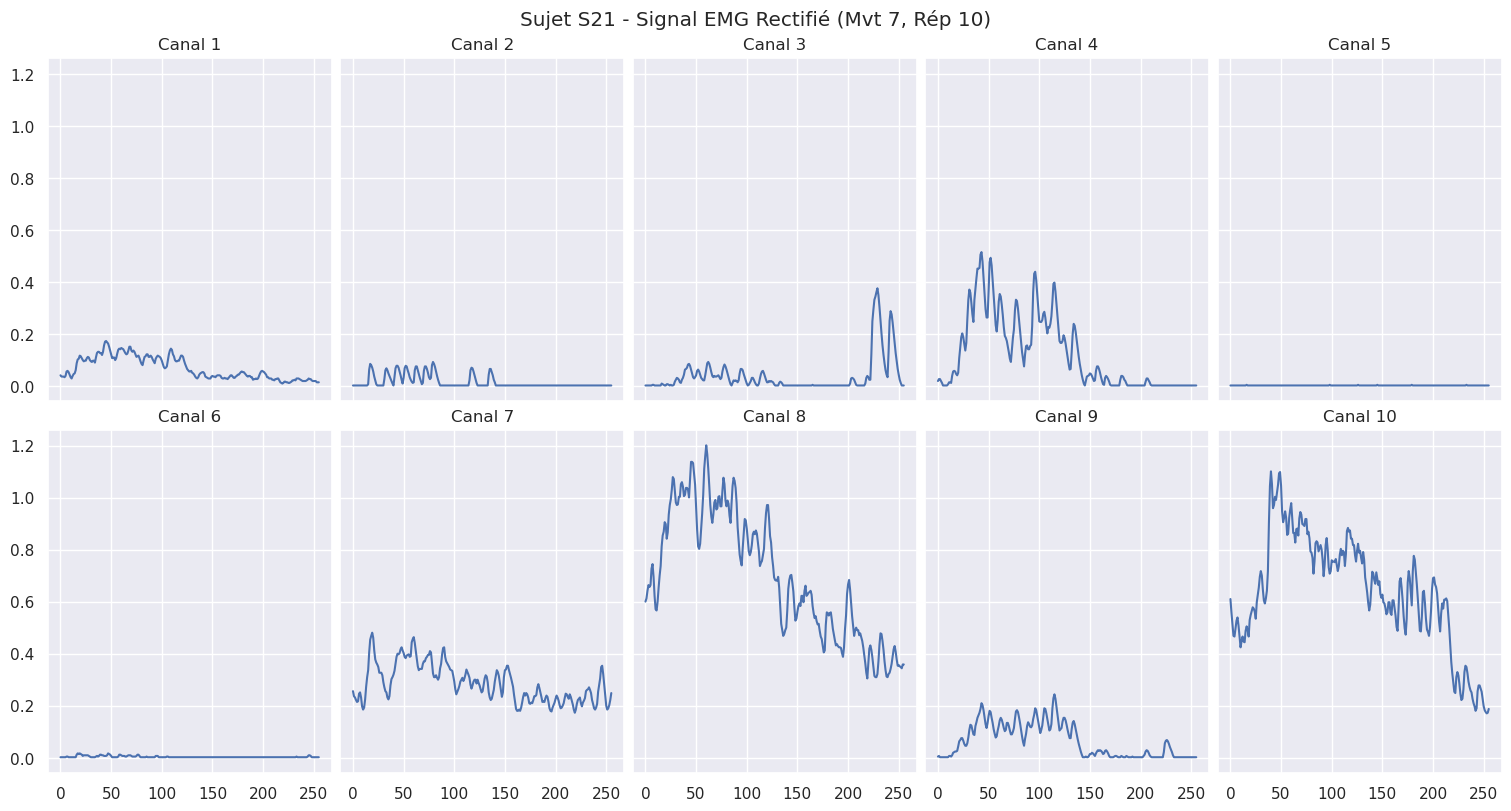

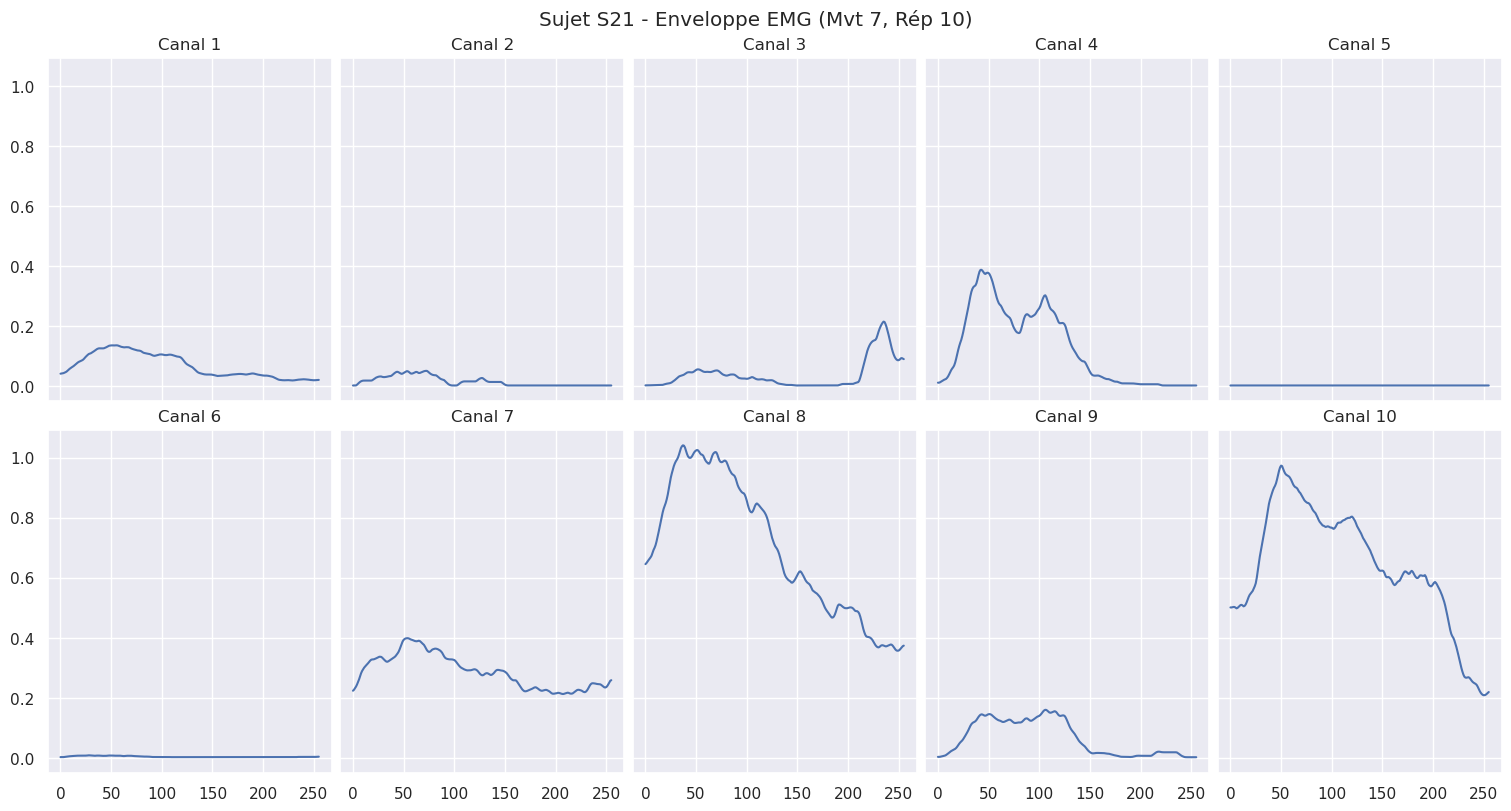

In [19]:
import matplotlib.pyplot as plt

# Définir le sujet à visualiser
SUBJECT_TO_PLOT = 'S21'
# Définir le mouvement et la répétition à visualiser
STIMULUS_INDEX_TO_PLOT = 6
REPETITION_INDEX_TO_PLOT = 9

if SUBJECT_TO_PLOT in all_processed:
    windows_data = all_processed[SUBJECT_TO_PLOT]["emg_windows"]
    envelopes_data = all_processed[SUBJECT_TO_PLOT]["emg_envelopes"]
    
    emg_window = windows_data[STIMULUS_INDEX_TO_PLOT][REPETITION_INDEX_TO_PLOT]
    emg_envelope = envelopes_data[STIMULUS_INDEX_TO_PLOT][REPETITION_INDEX_TO_PLOT]
    
    if emg_window is not None:
        number_of_emg_channels = emg_window.shape[1] 

        # --- Plot des signaux Rectifiés (Windows) ---
        fig, ax = plt.subplots(2, 5, figsize=(15, 8), constrained_layout=True, sharex=True, sharey=True)
        ax = ax.ravel()
        for channel_idx in range(number_of_emg_channels): 
            ax[channel_idx].plot(emg_window[:, channel_idx])
            ax[channel_idx].set_title(f"Canal {channel_idx+1}")
        plt.suptitle(f"Sujet {SUBJECT_TO_PLOT} - Signal EMG Rectifié (Mvt {STIMULUS_INDEX_TO_PLOT+1}, Rép {REPETITION_INDEX_TO_PLOT+1})")
        plt.show() 

        # --- Plot des Enveloppes (Moving Average) ---
        fig, ax = plt.subplots(2, 5, figsize=(15, 8), constrained_layout=True, sharex=True, sharey=True)
        ax = ax.ravel()
        for channel_idx in range(number_of_emg_channels): 
            ax[channel_idx].plot(emg_envelope[:, channel_idx])
            ax[channel_idx].set_title(f"Canal {channel_idx+1}")
        plt.suptitle(f"Sujet {SUBJECT_TO_PLOT} - Enveloppe EMG (Mvt {STIMULUS_INDEX_TO_PLOT+1}, Rép {REPETITION_INDEX_TO_PLOT+1})")
        plt.show()

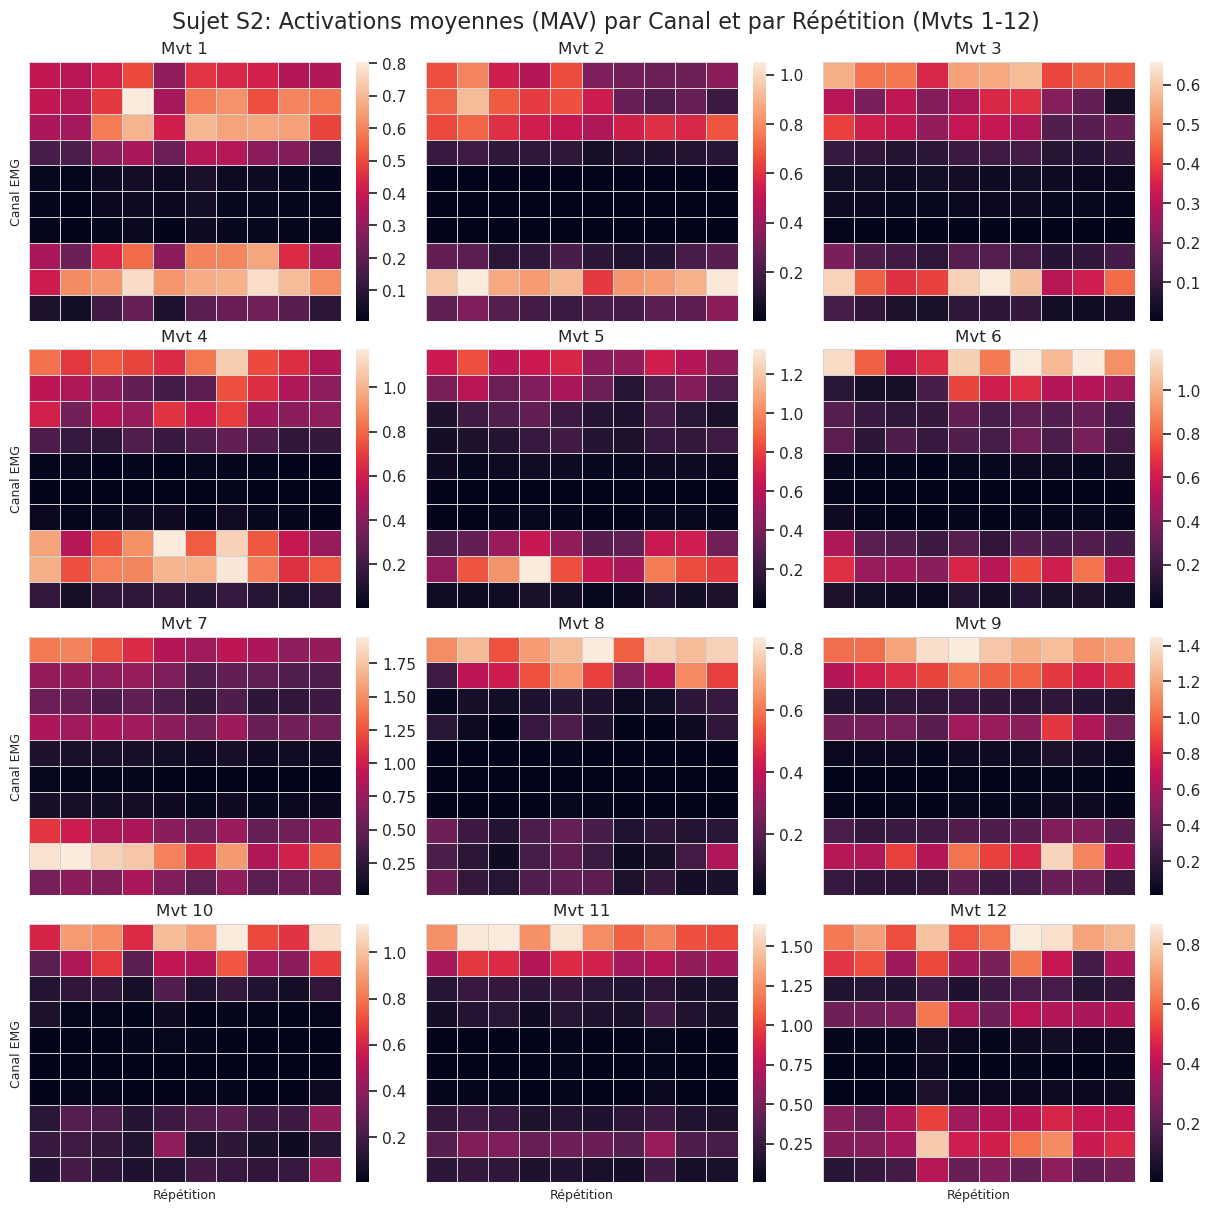

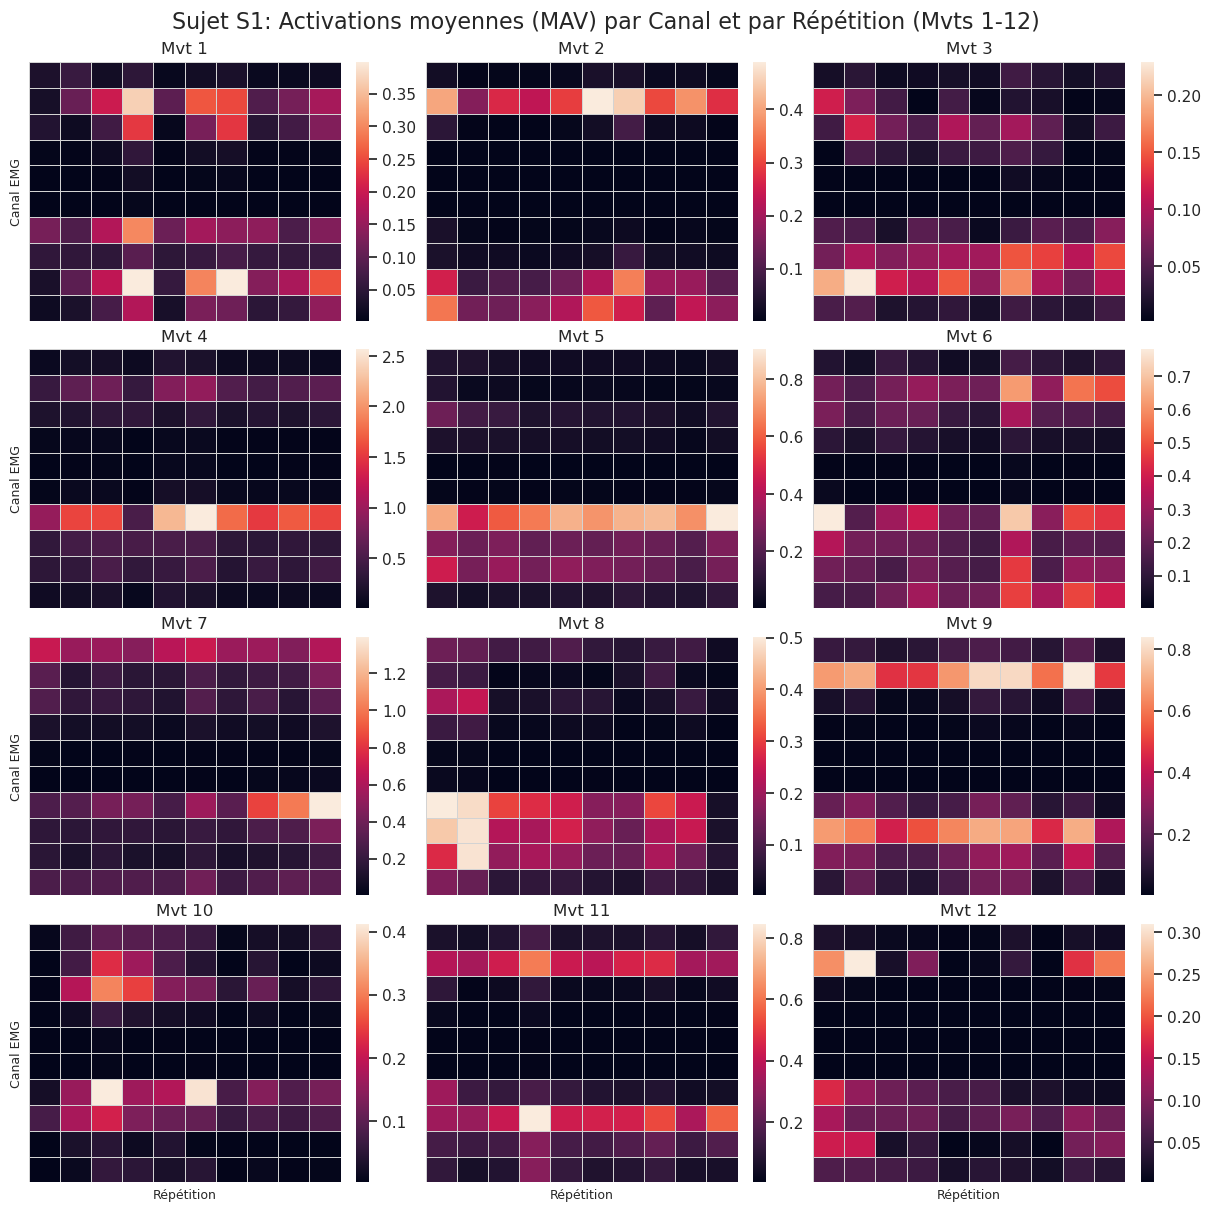

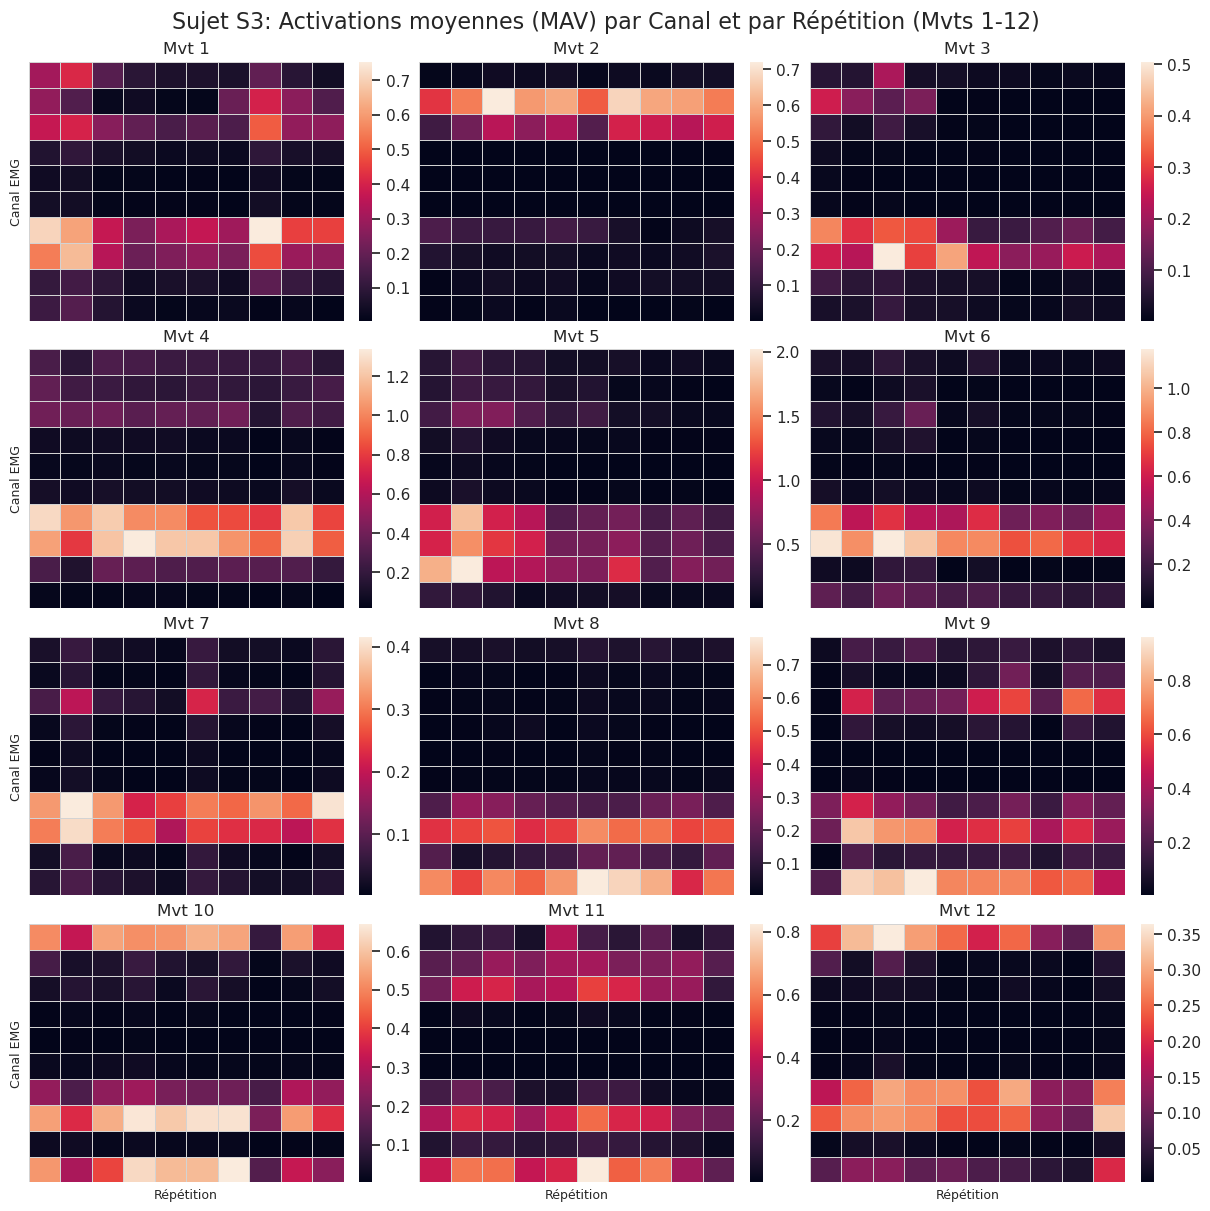

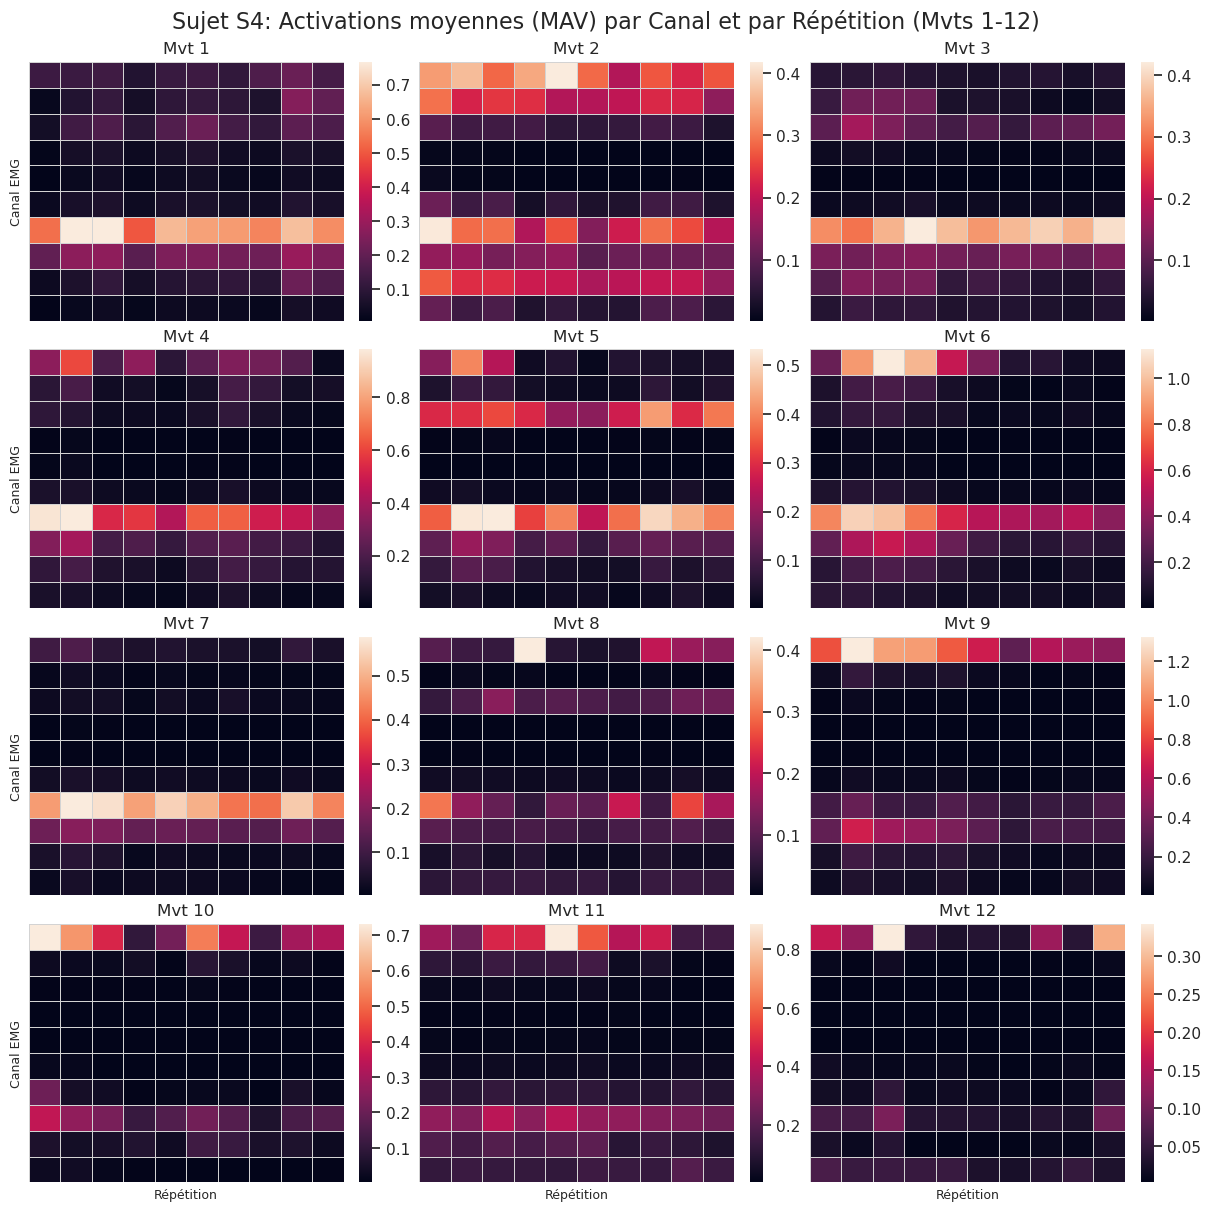

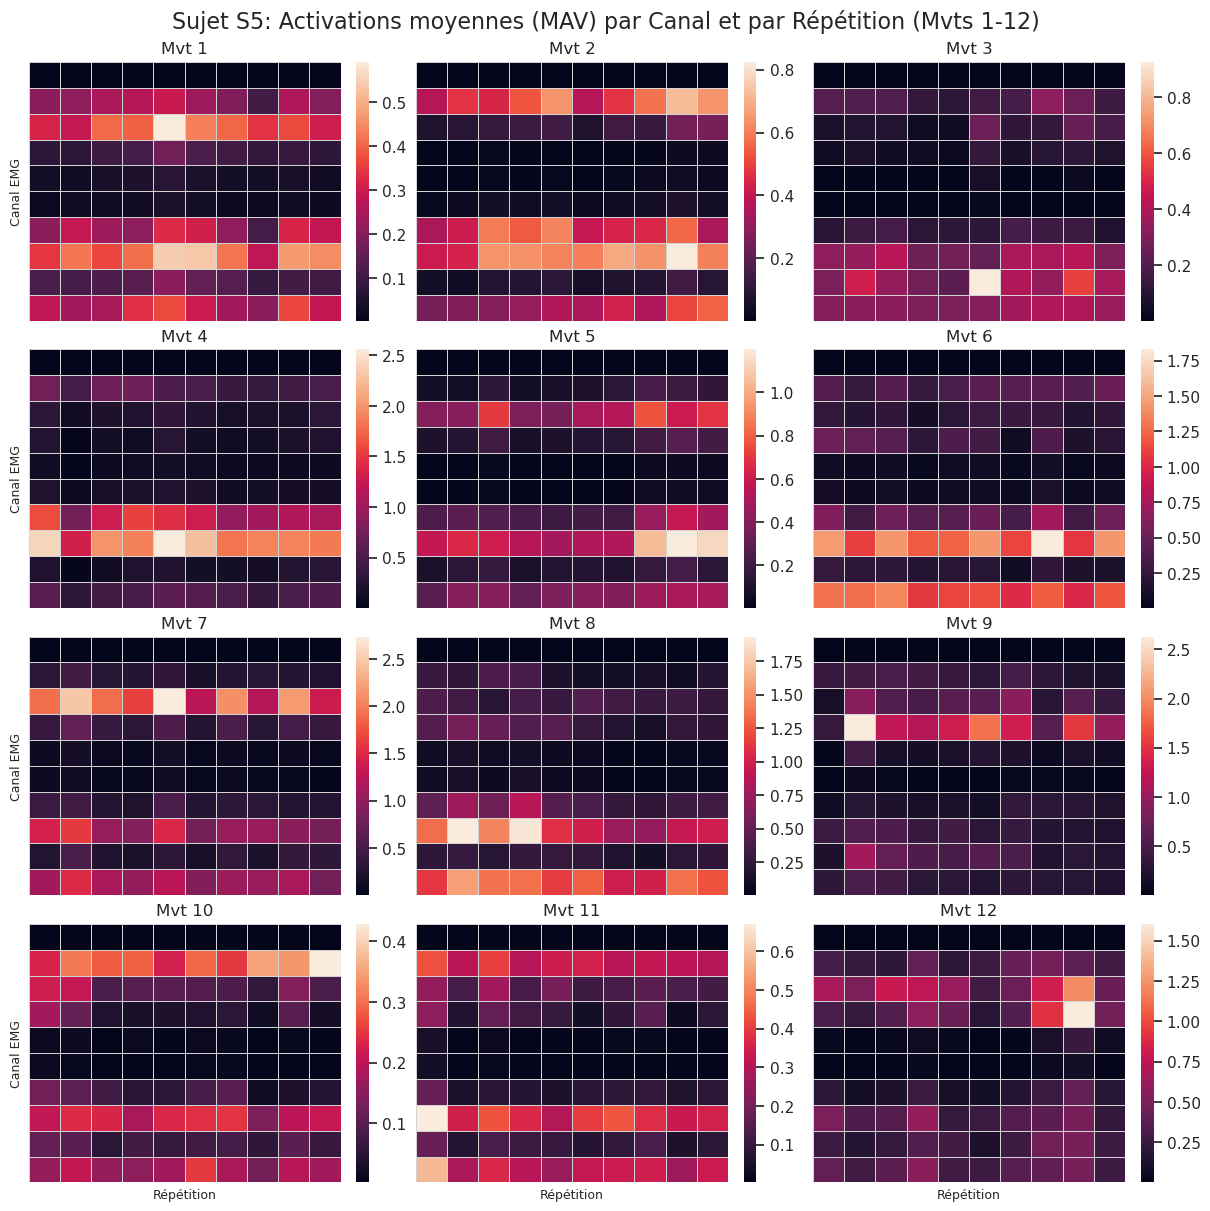

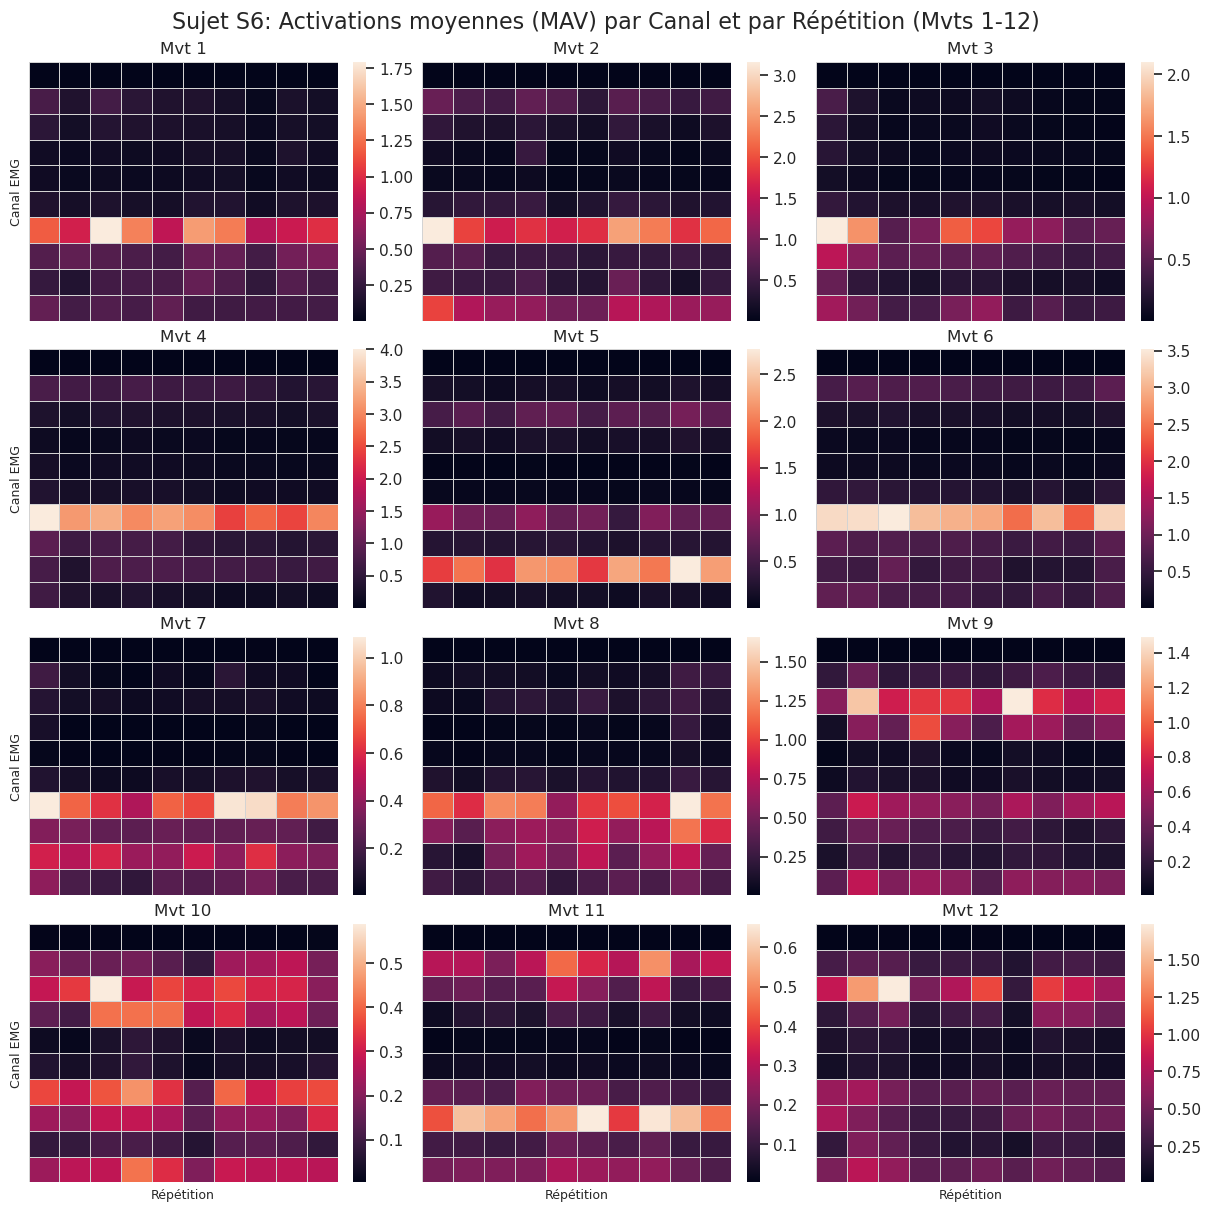

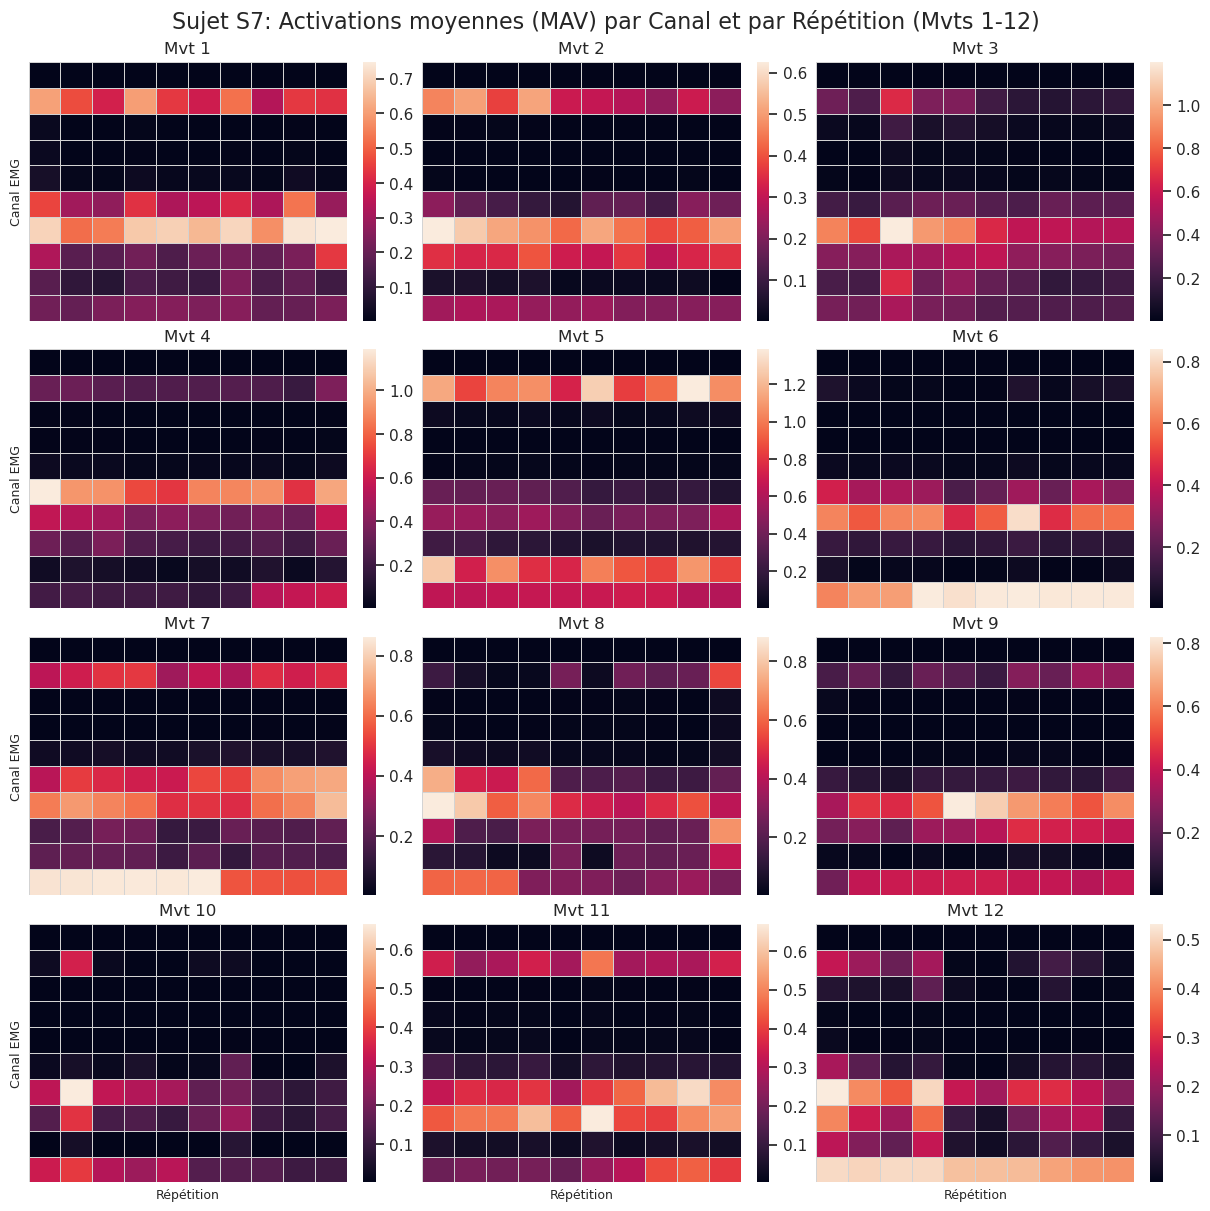

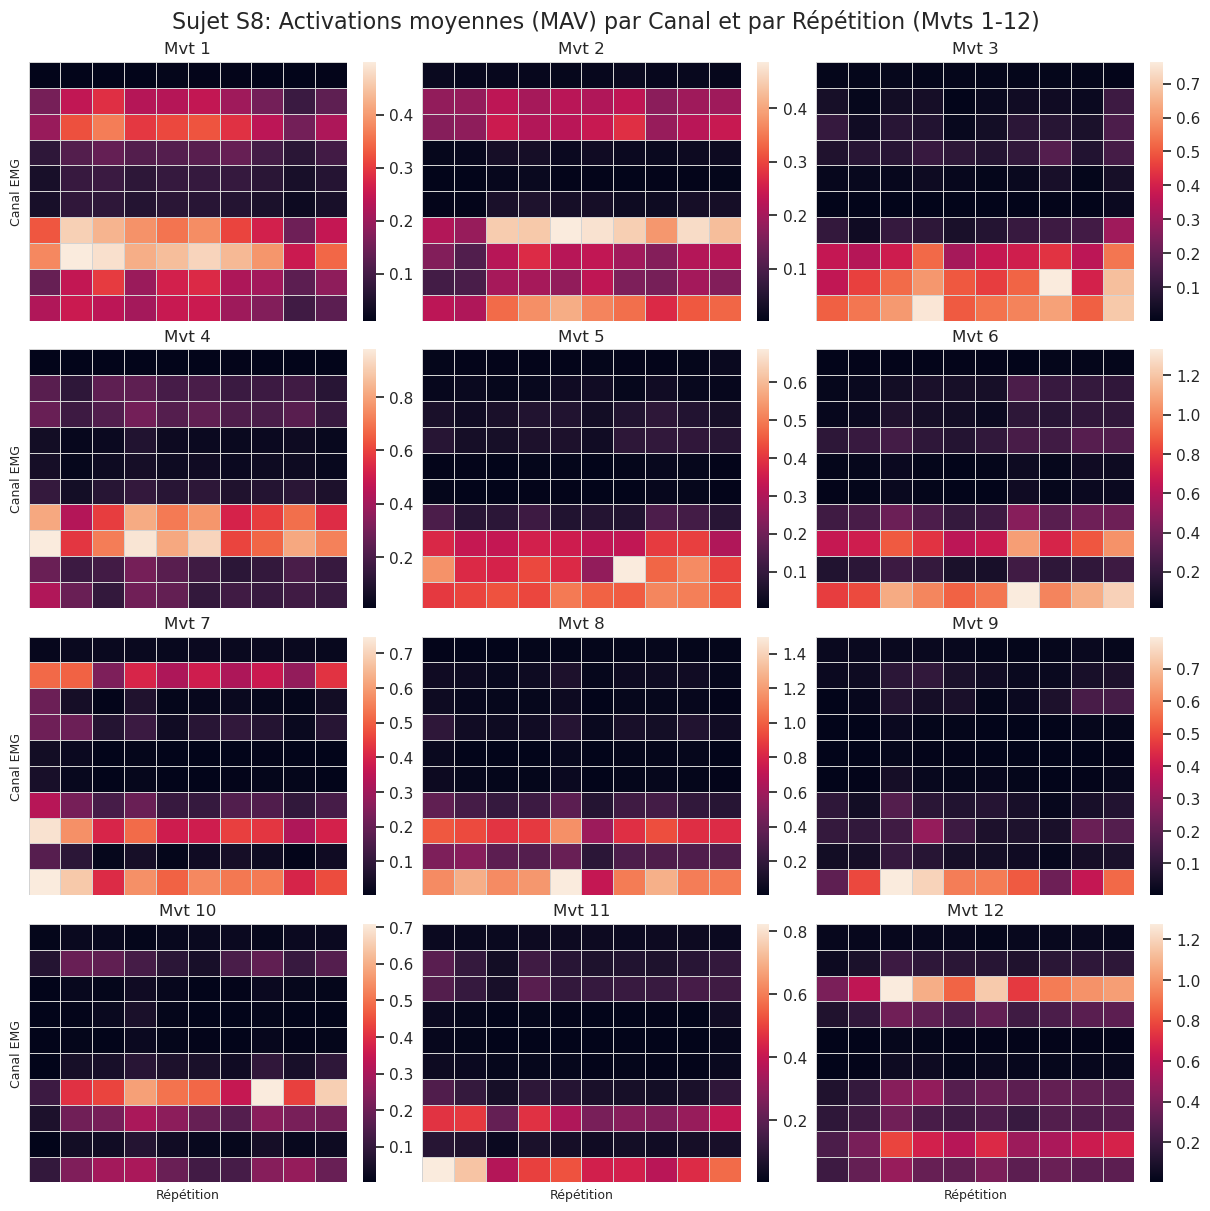

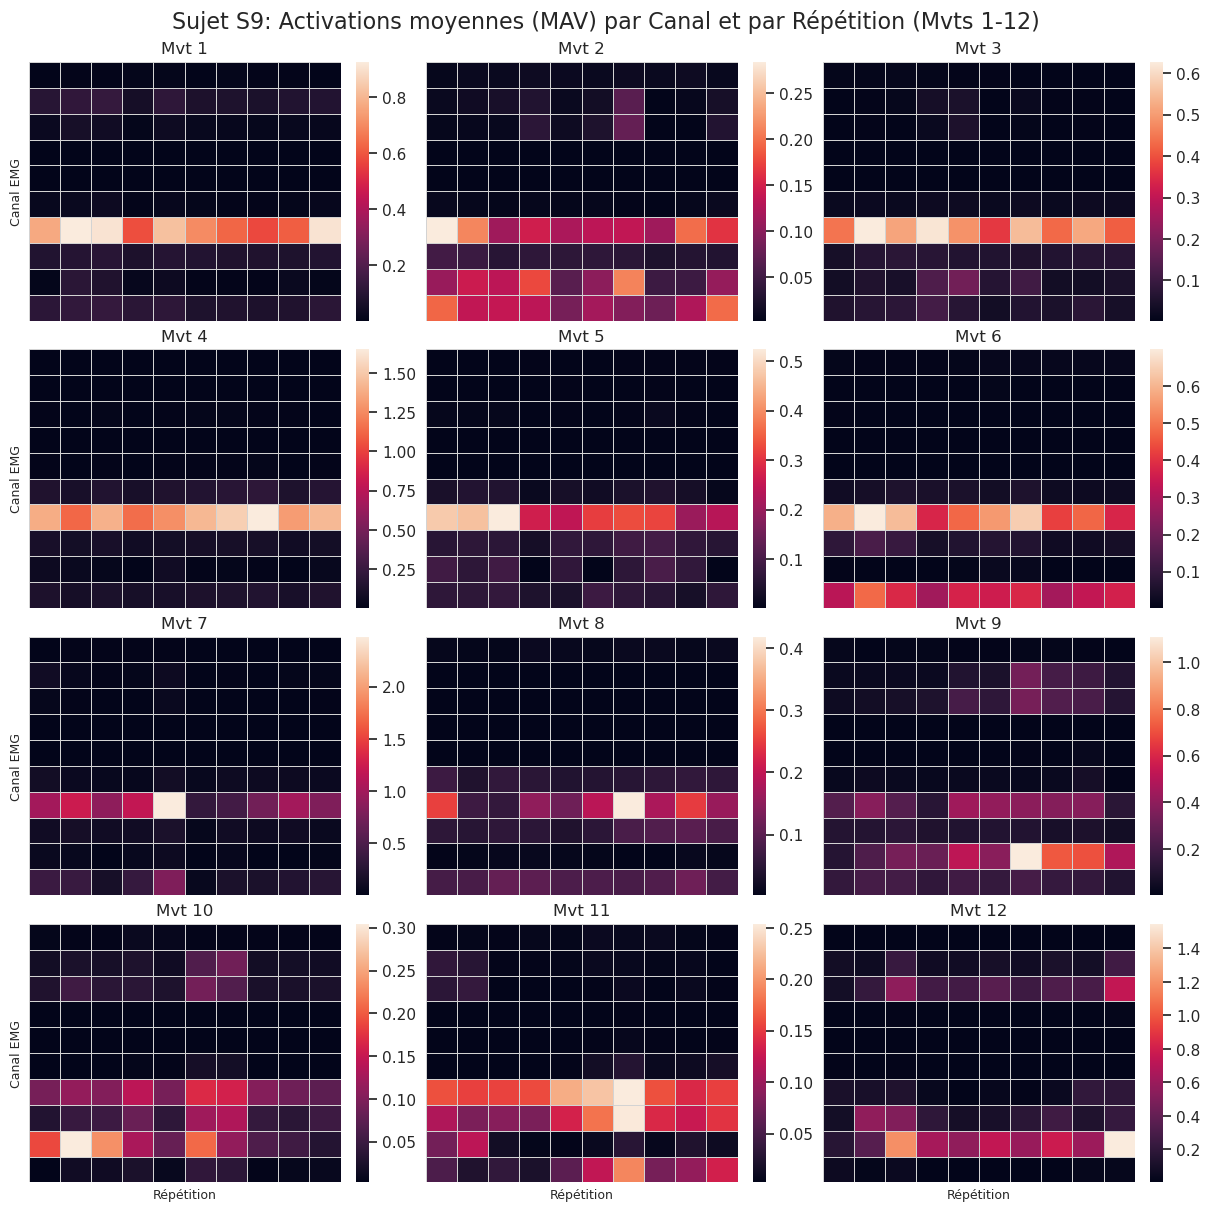

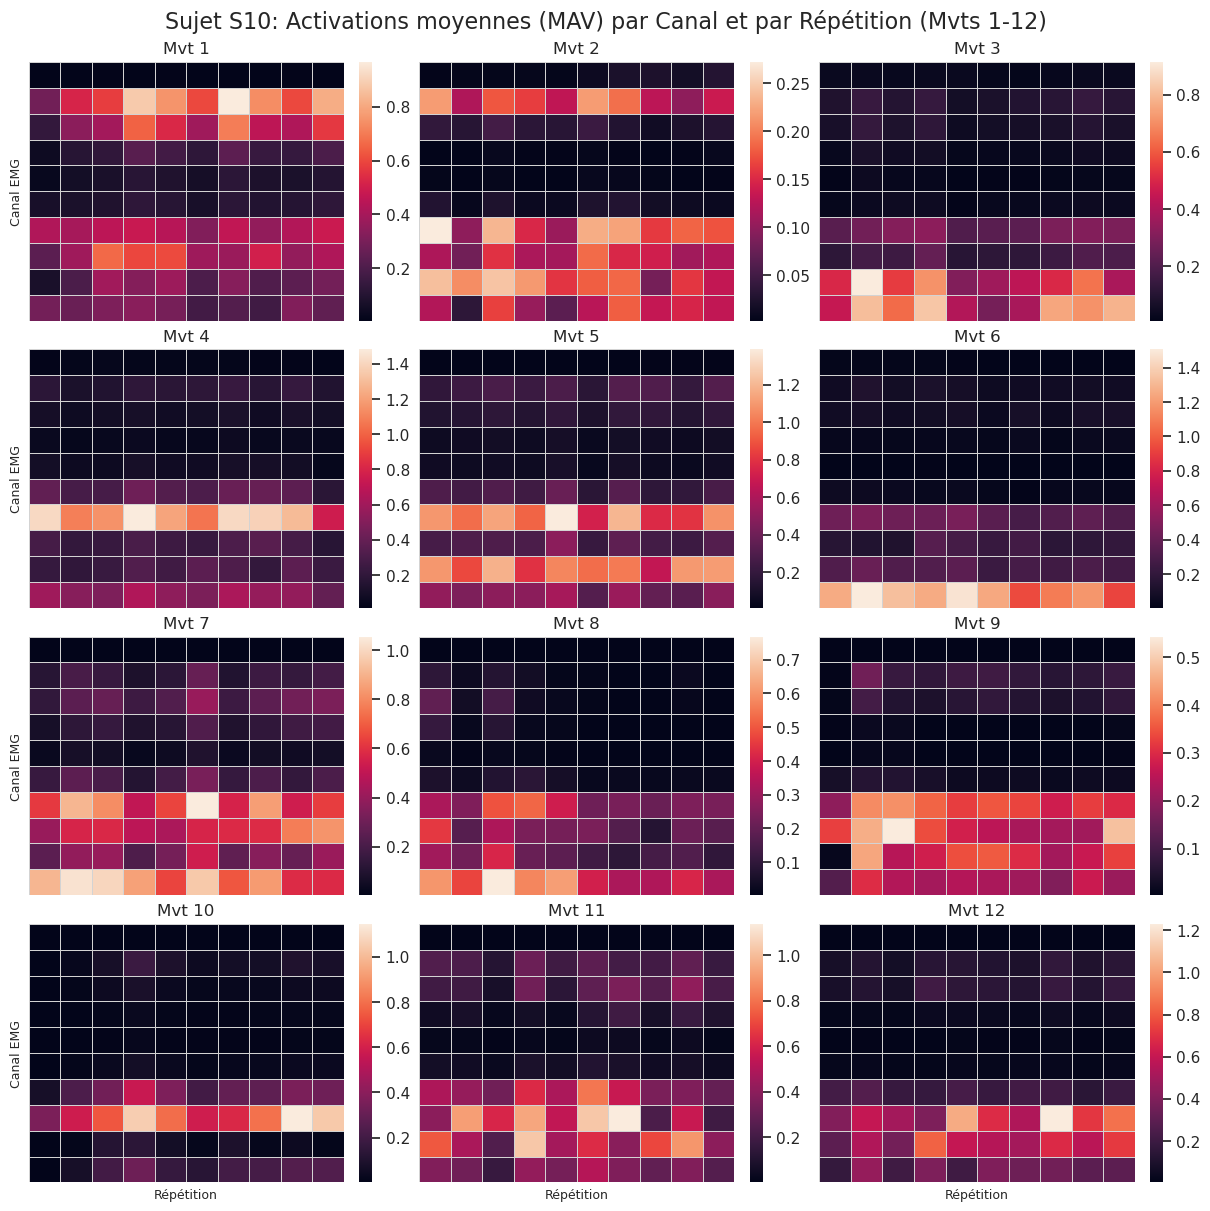

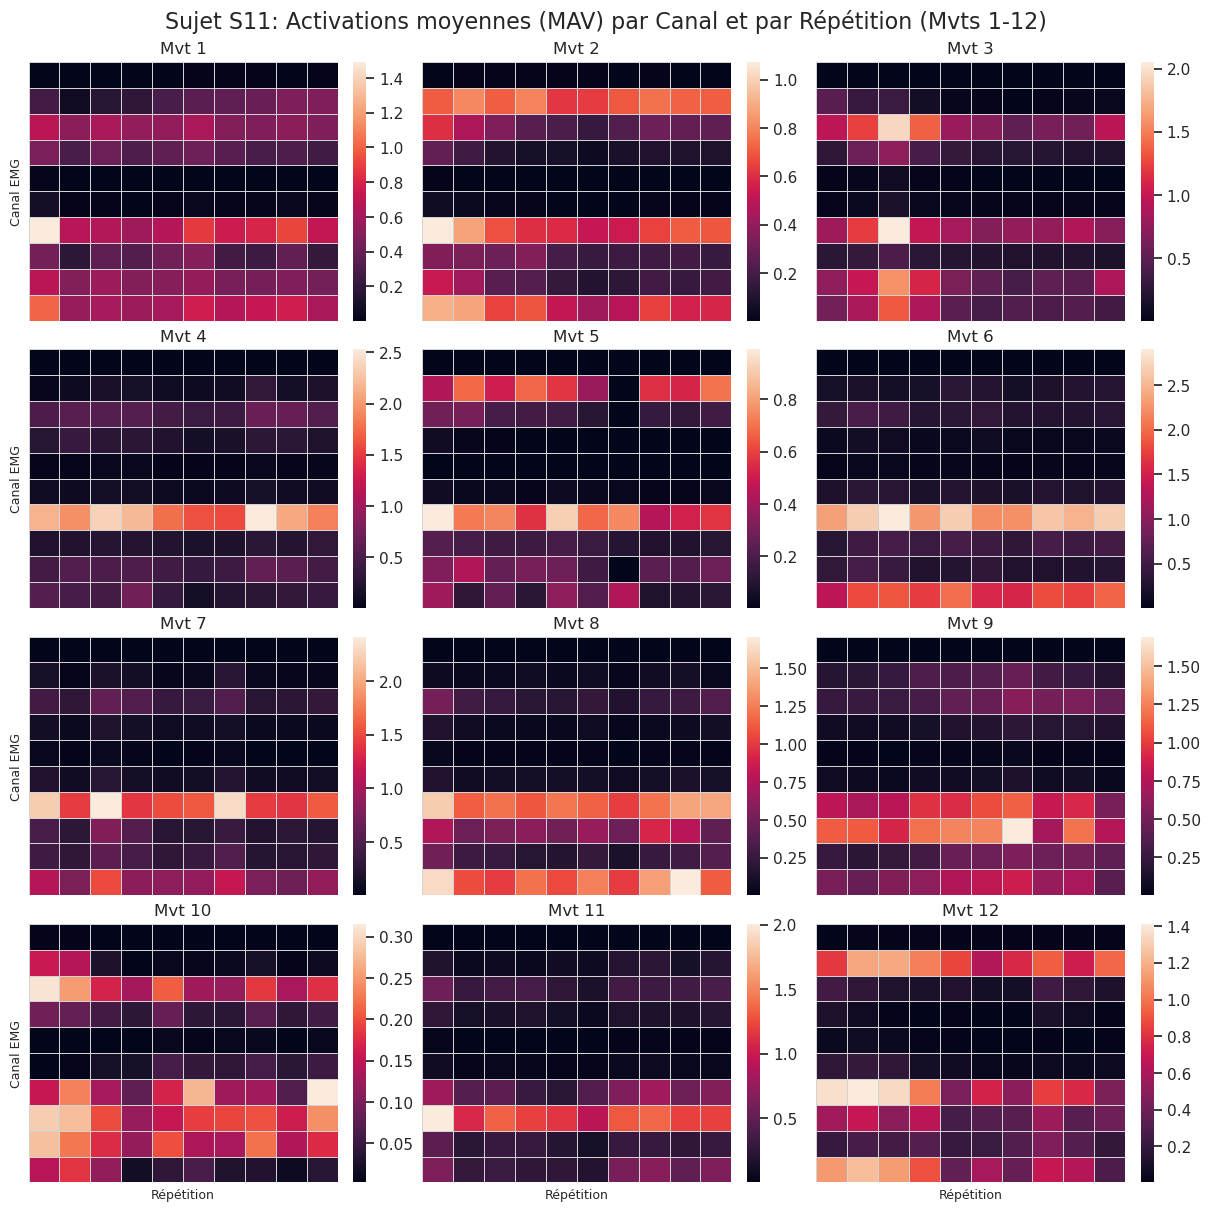

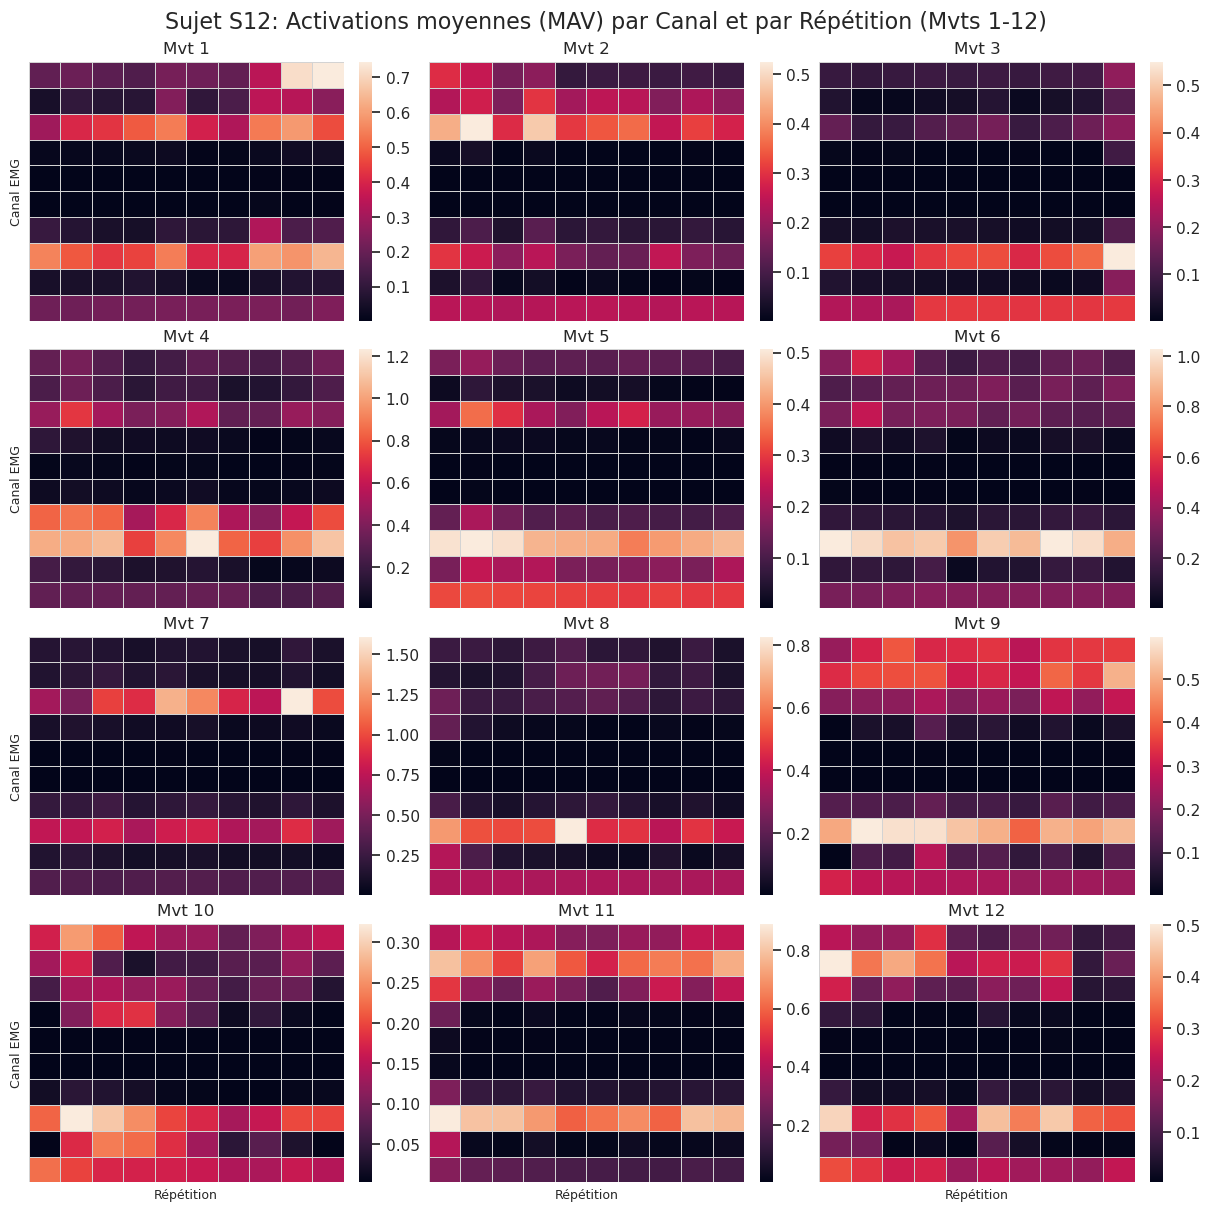

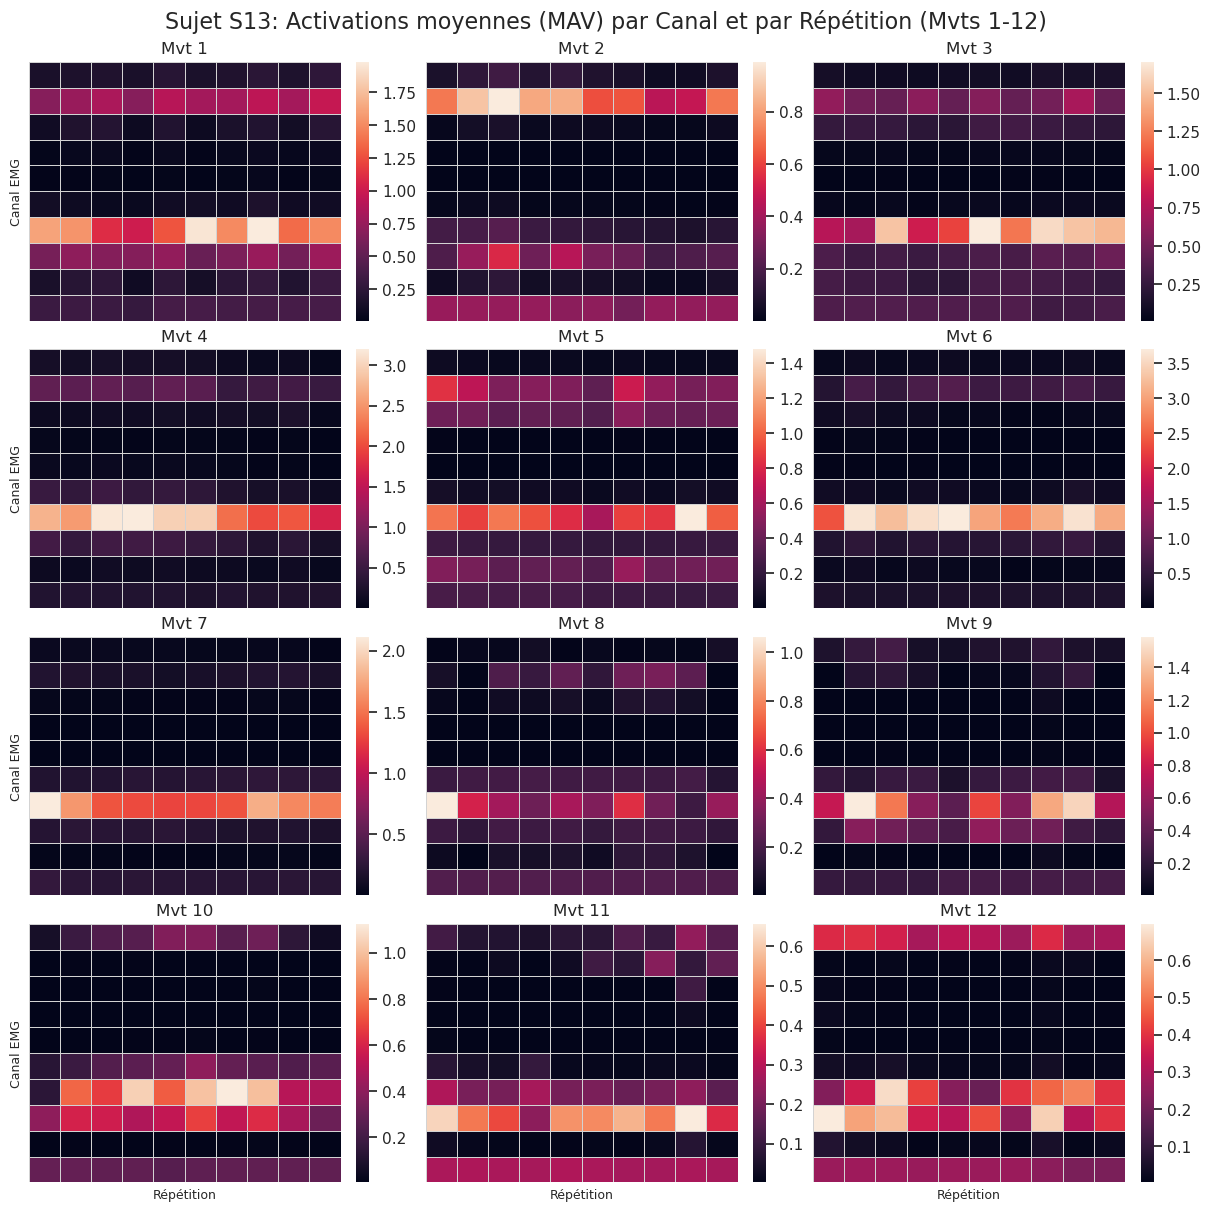

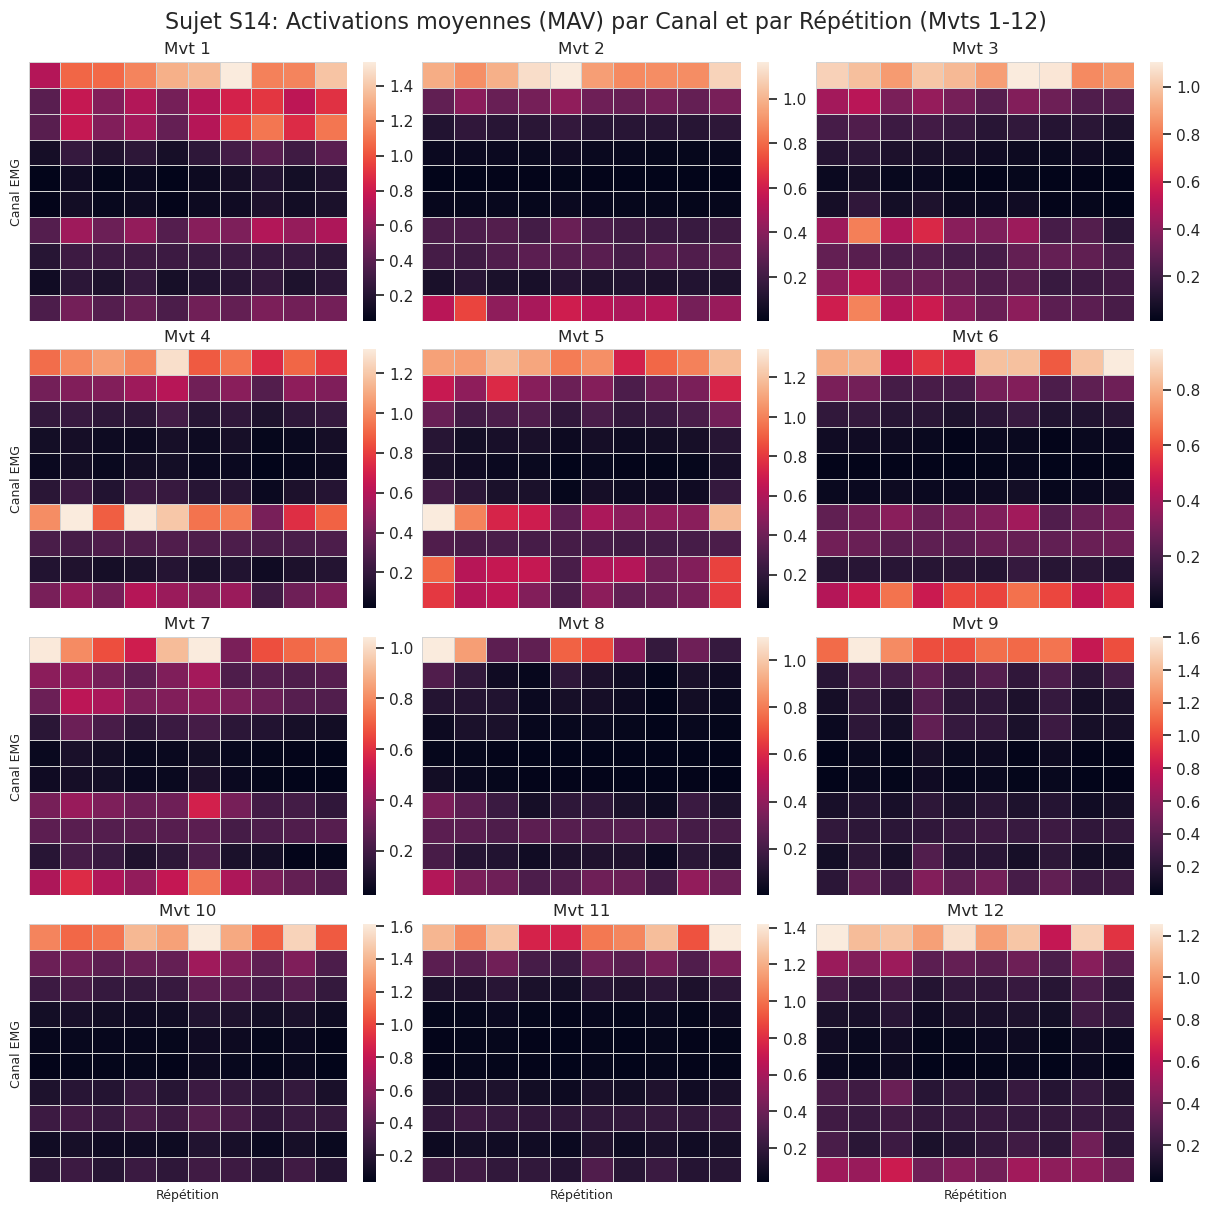

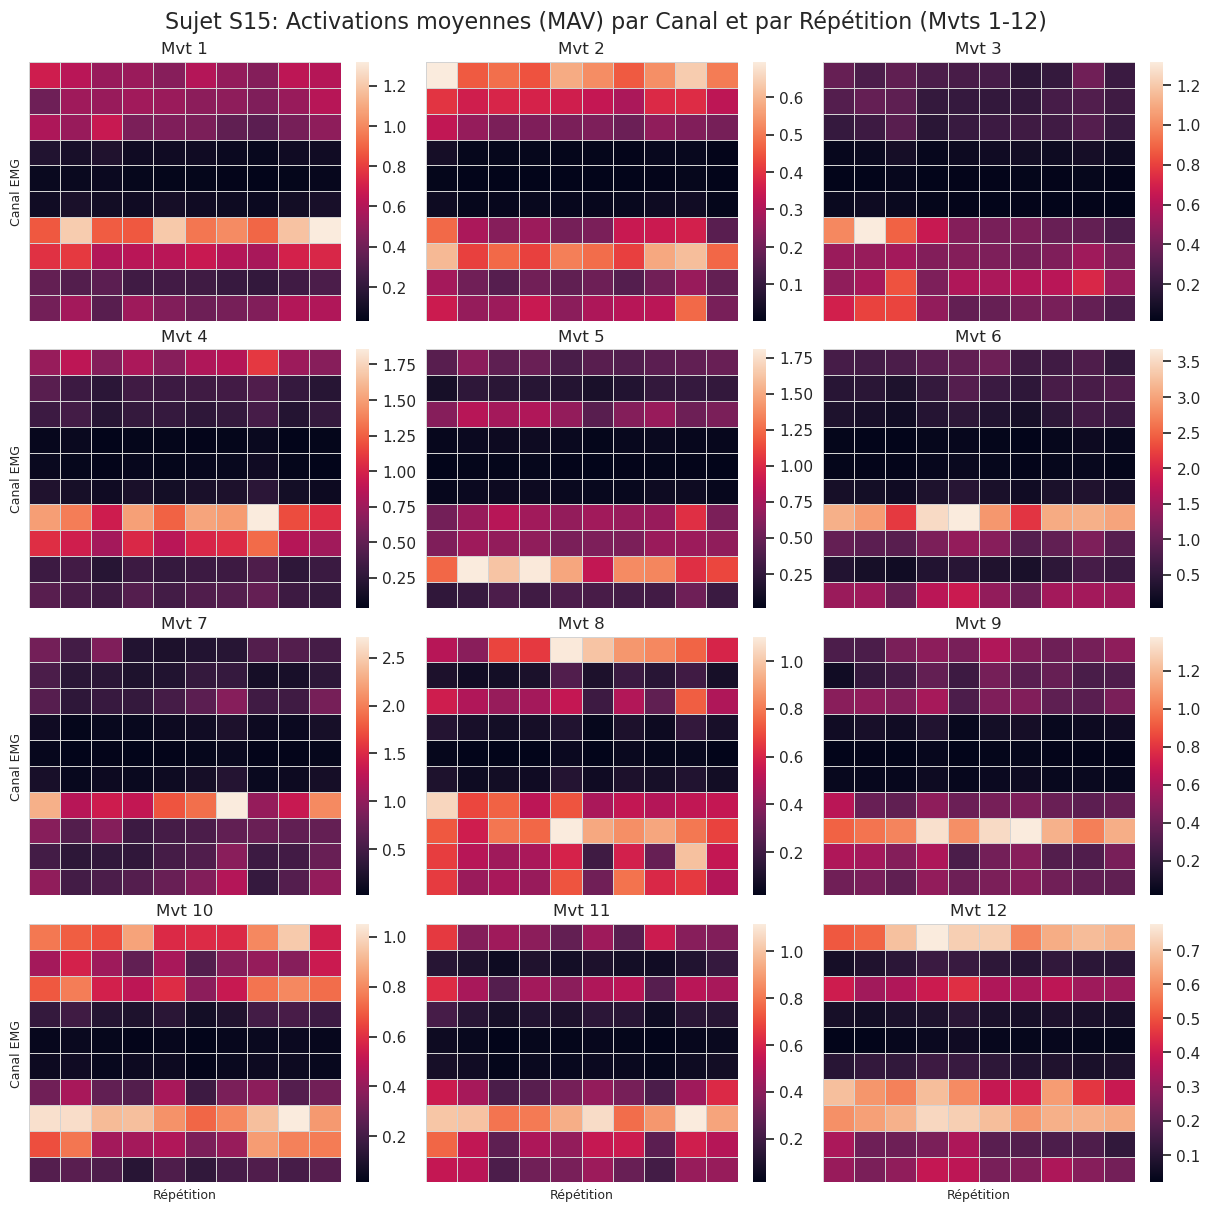

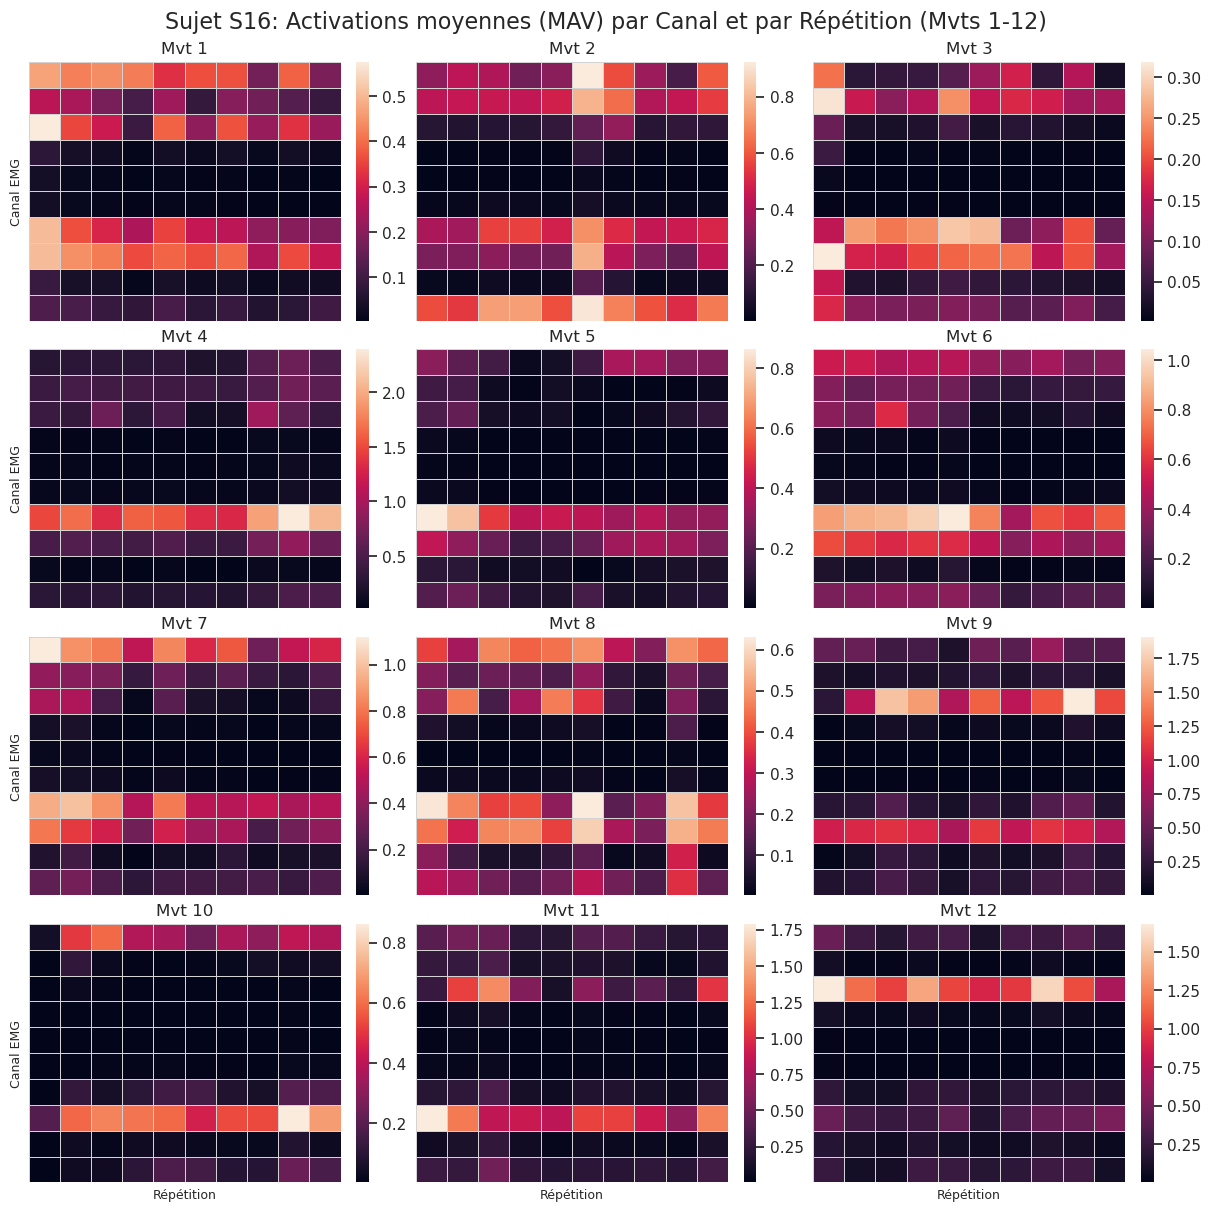

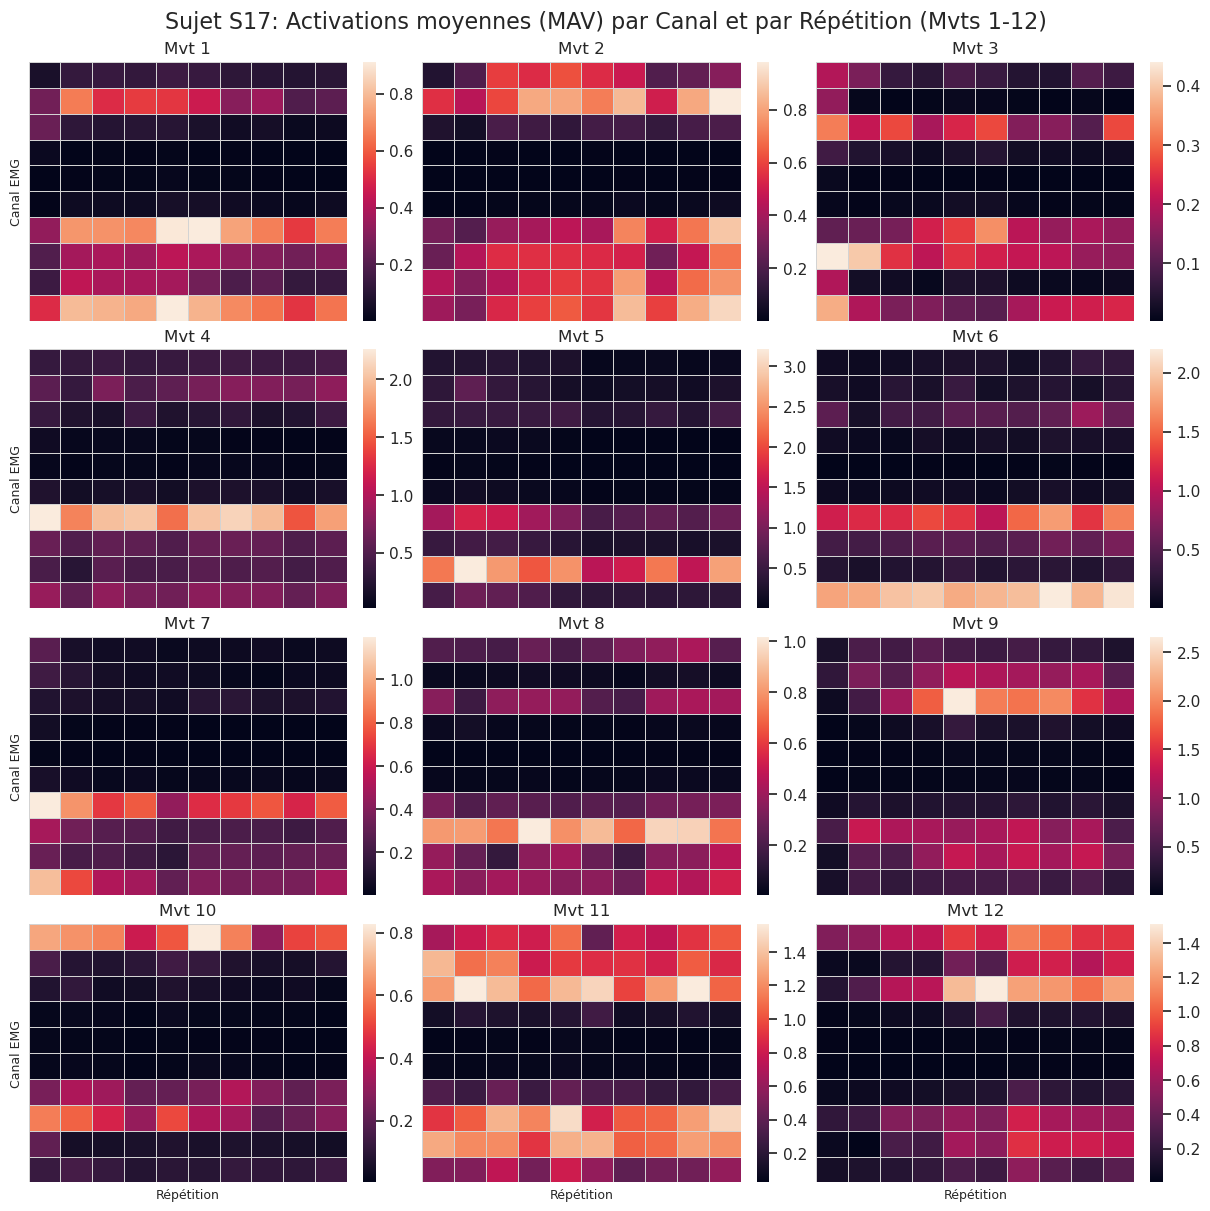

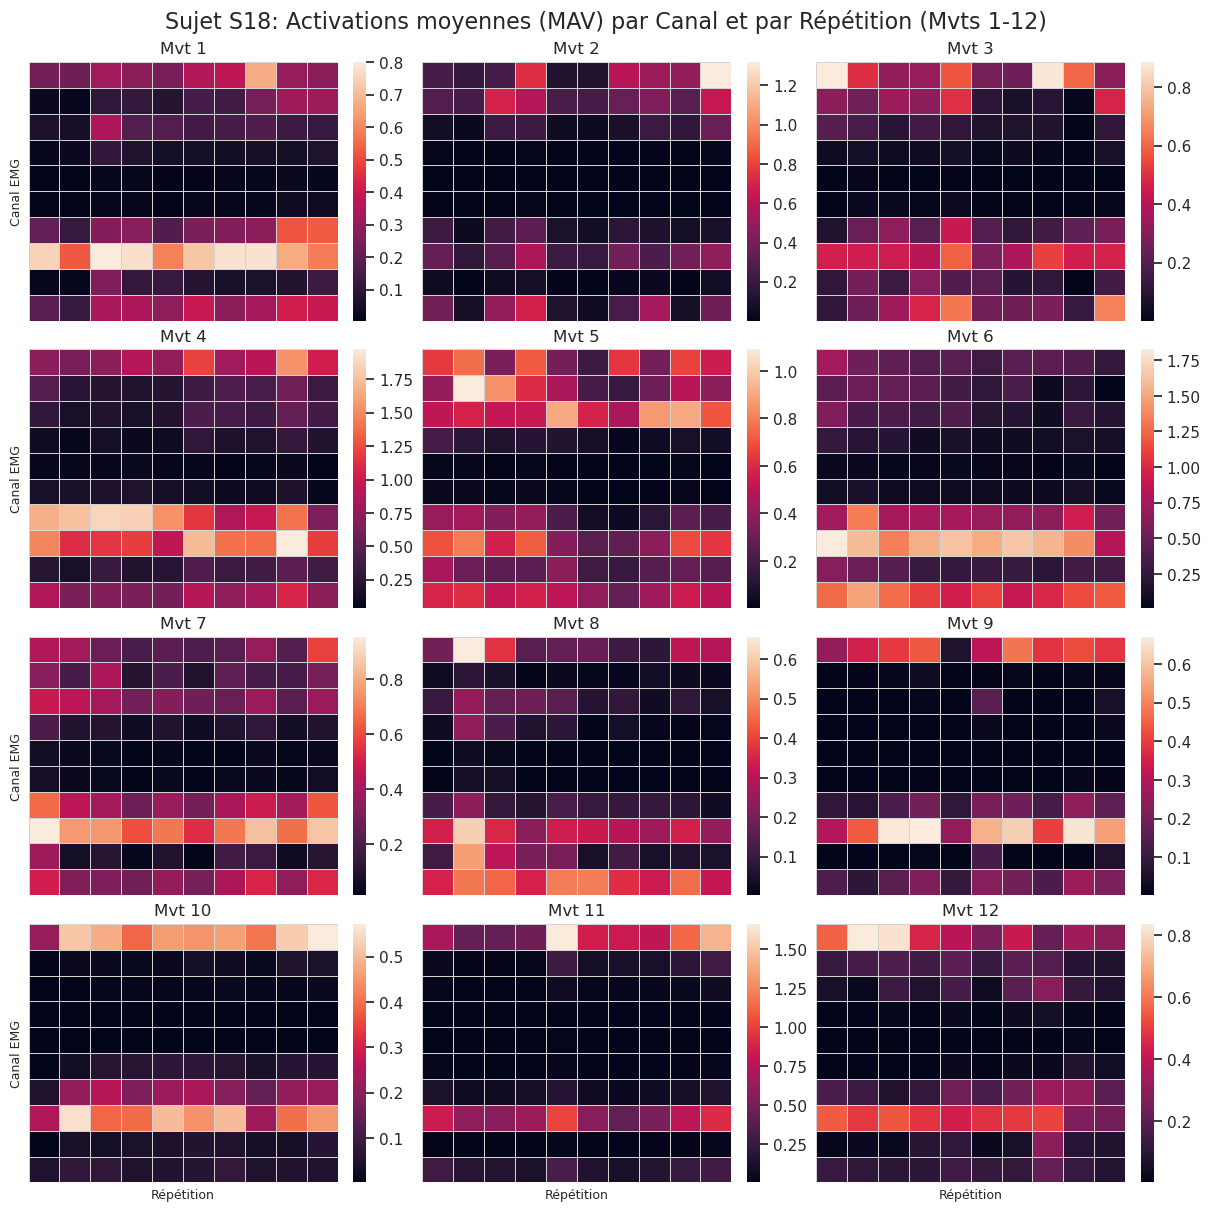

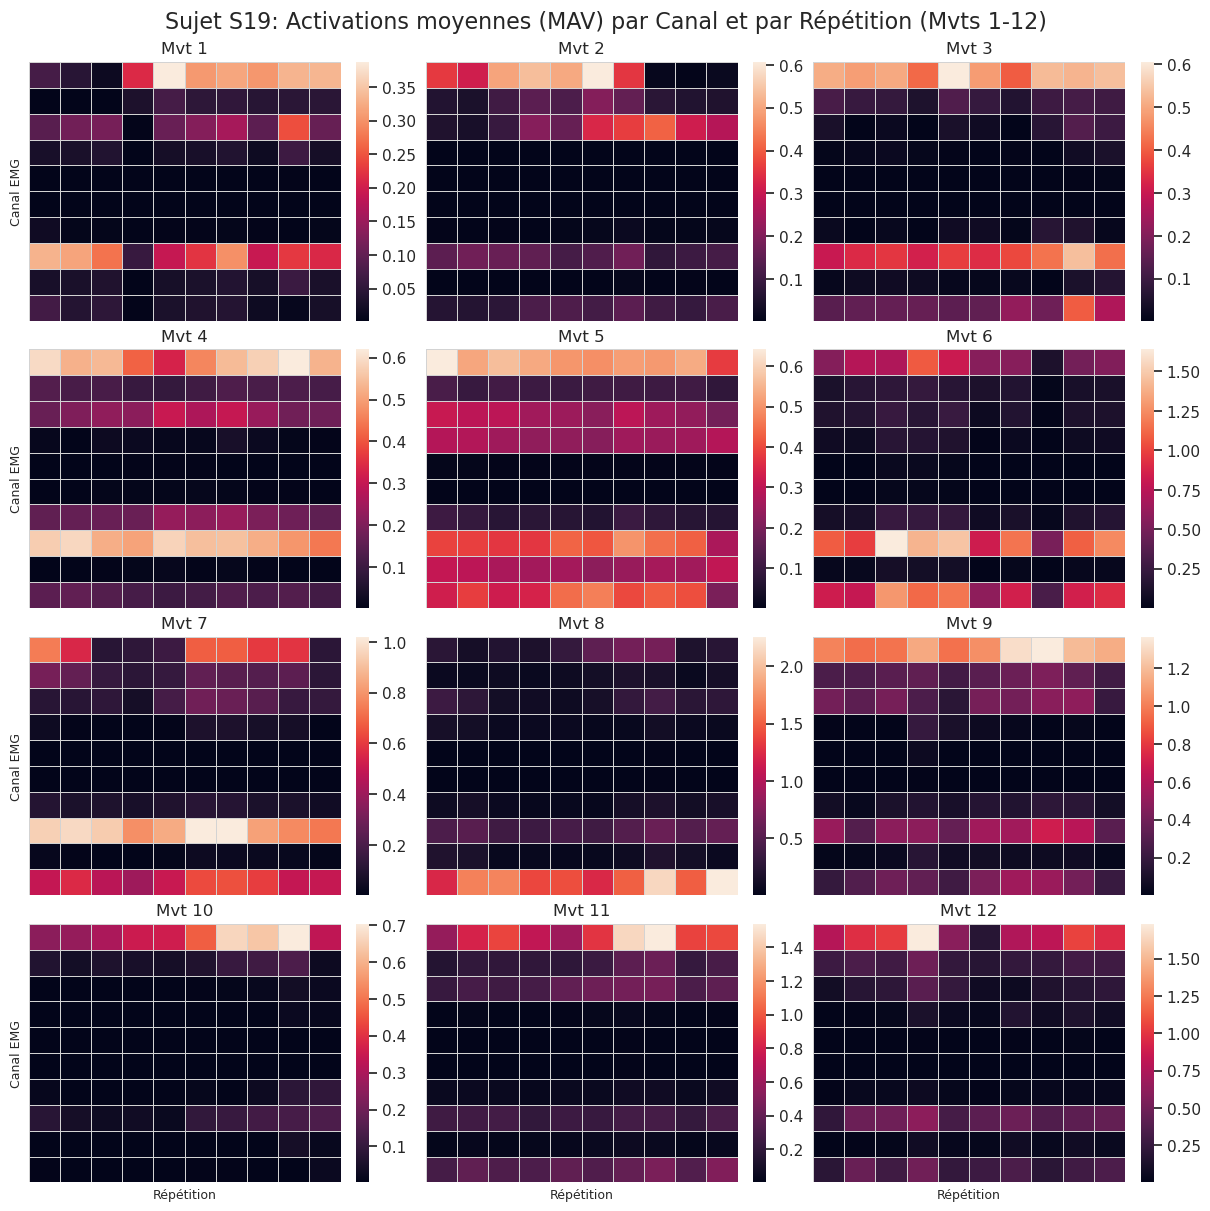

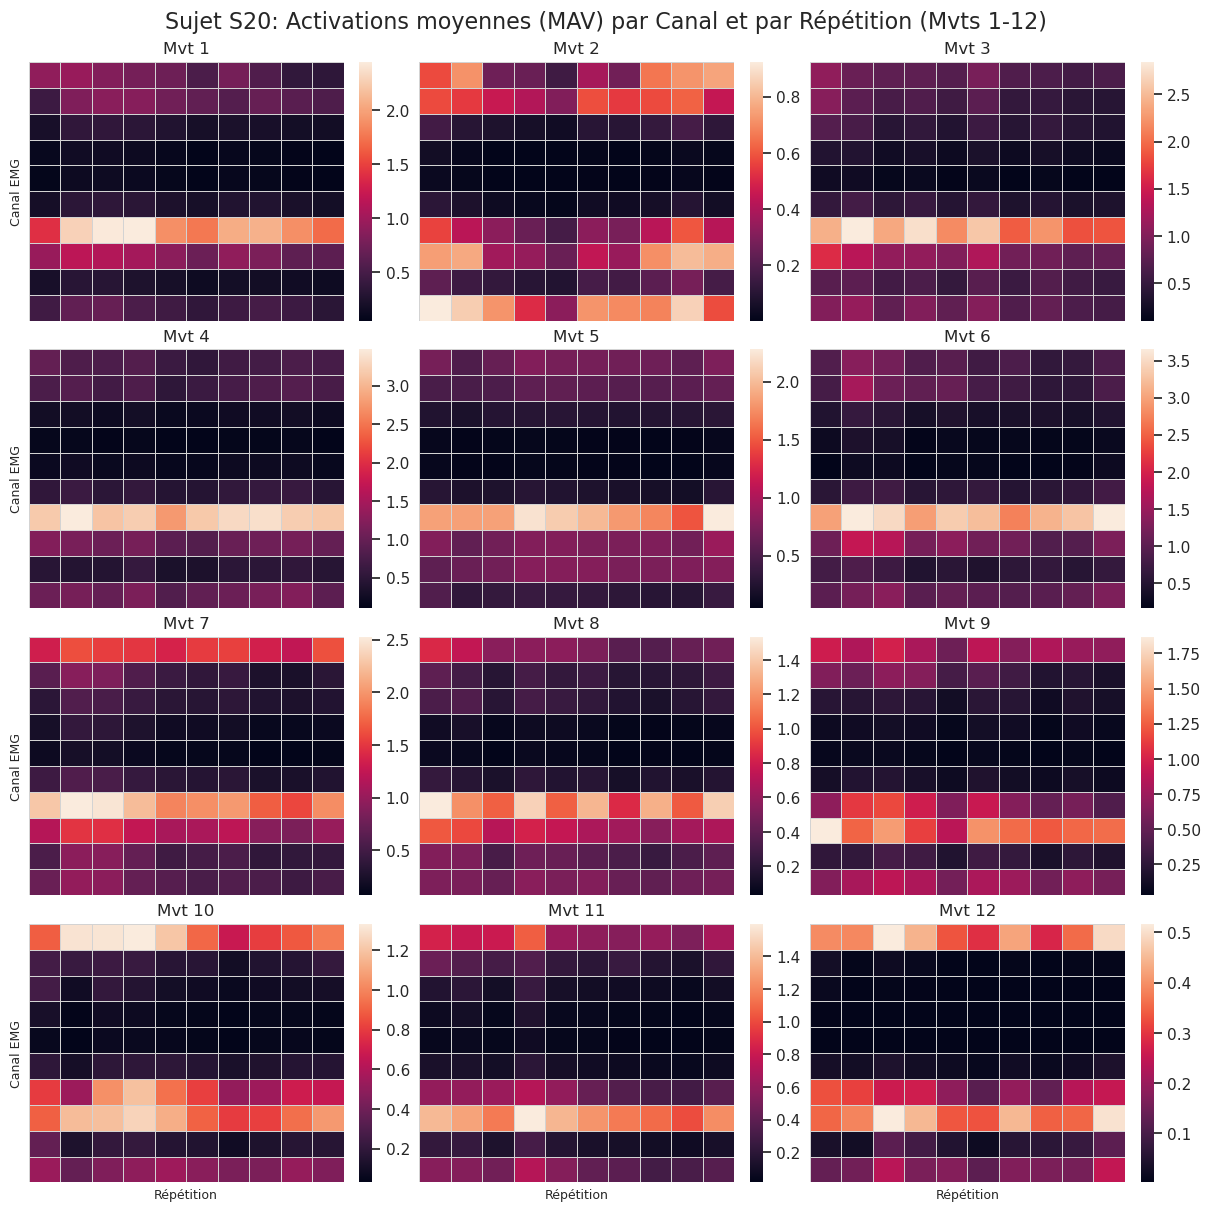

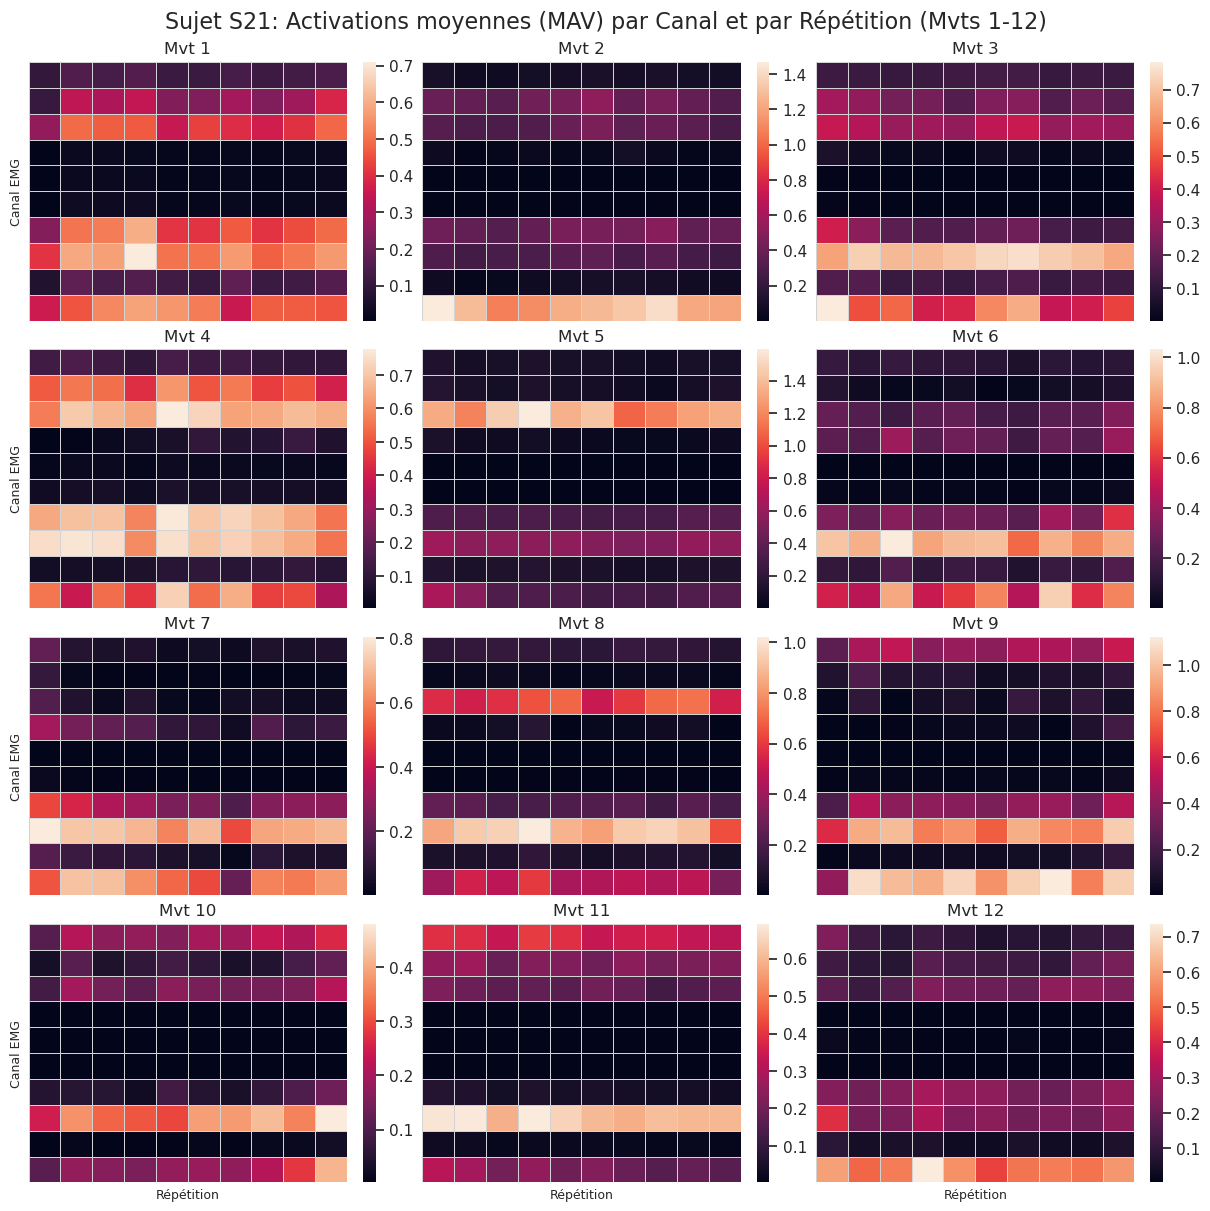

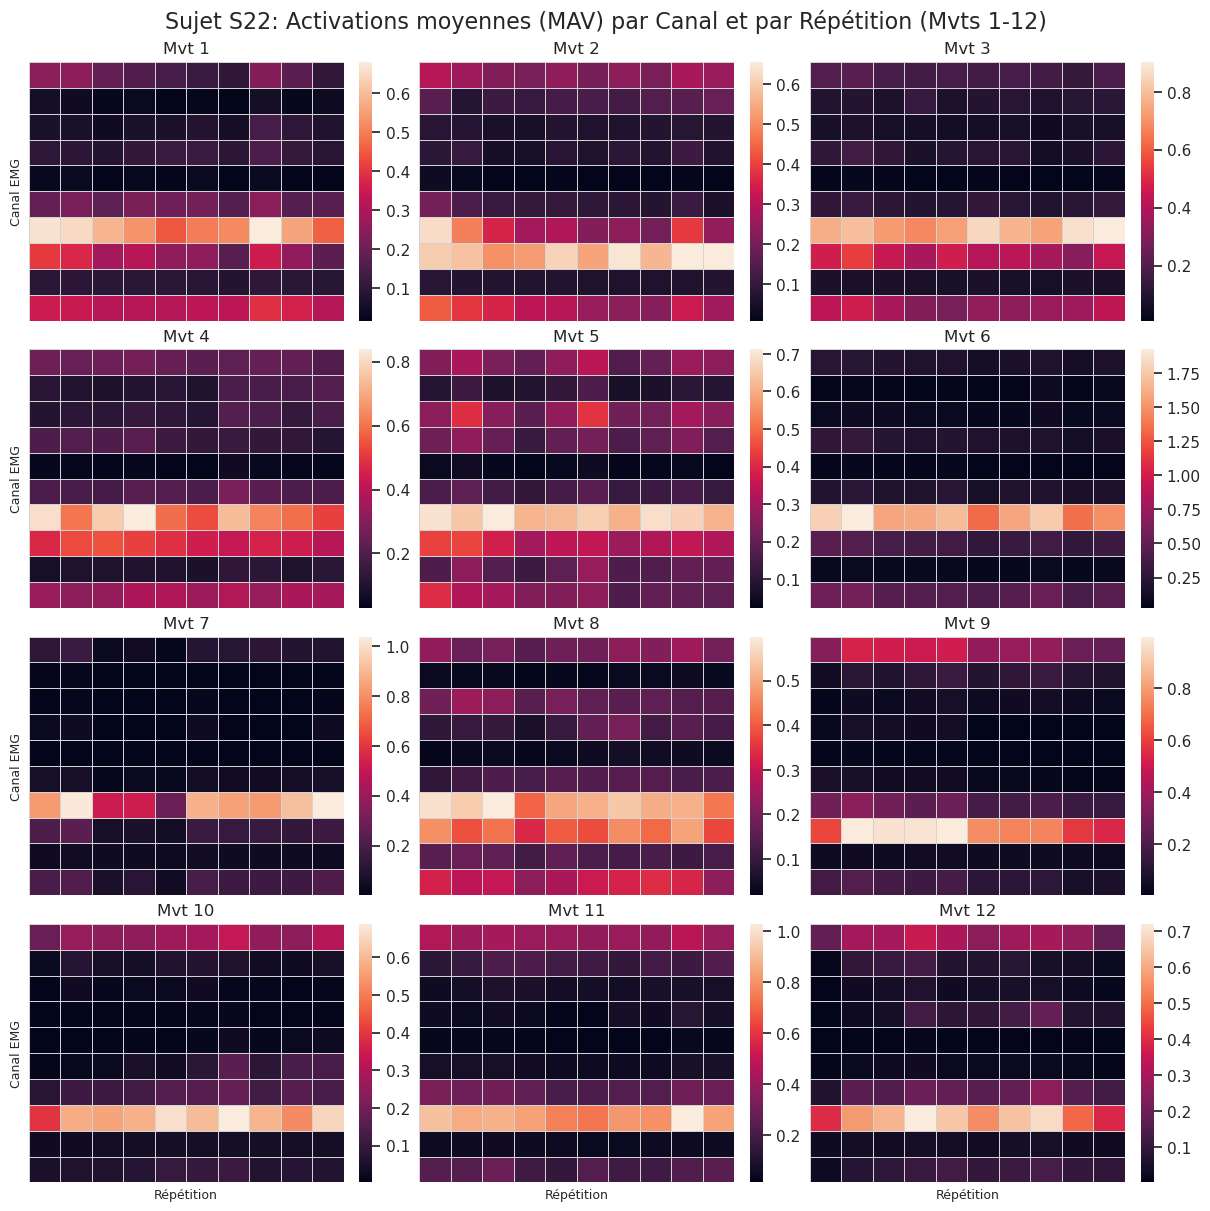

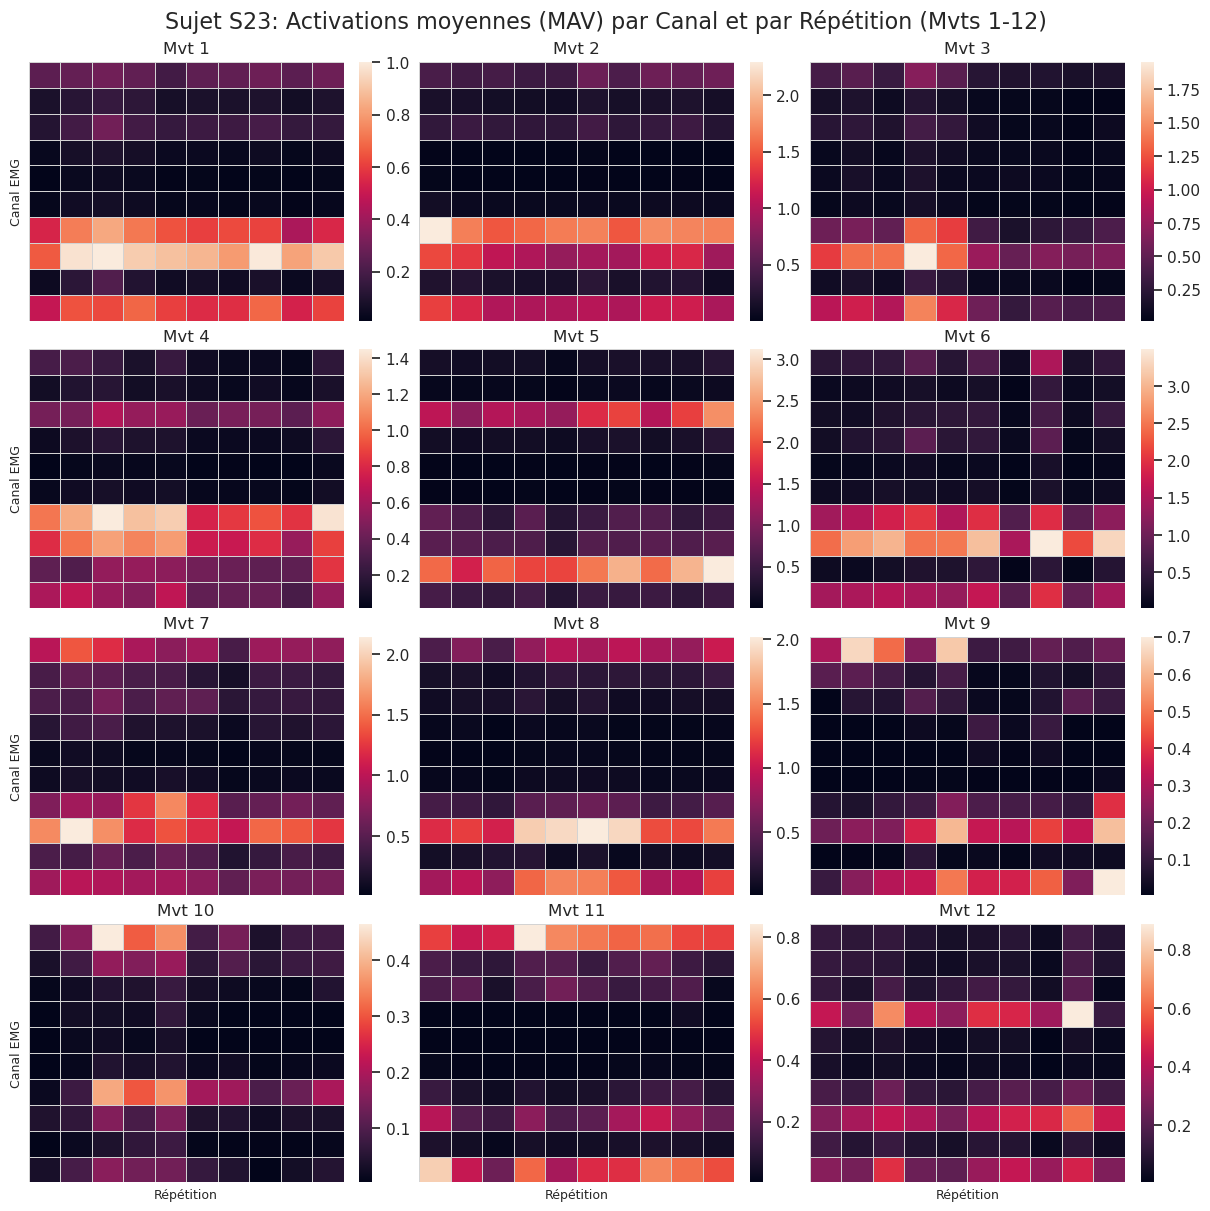

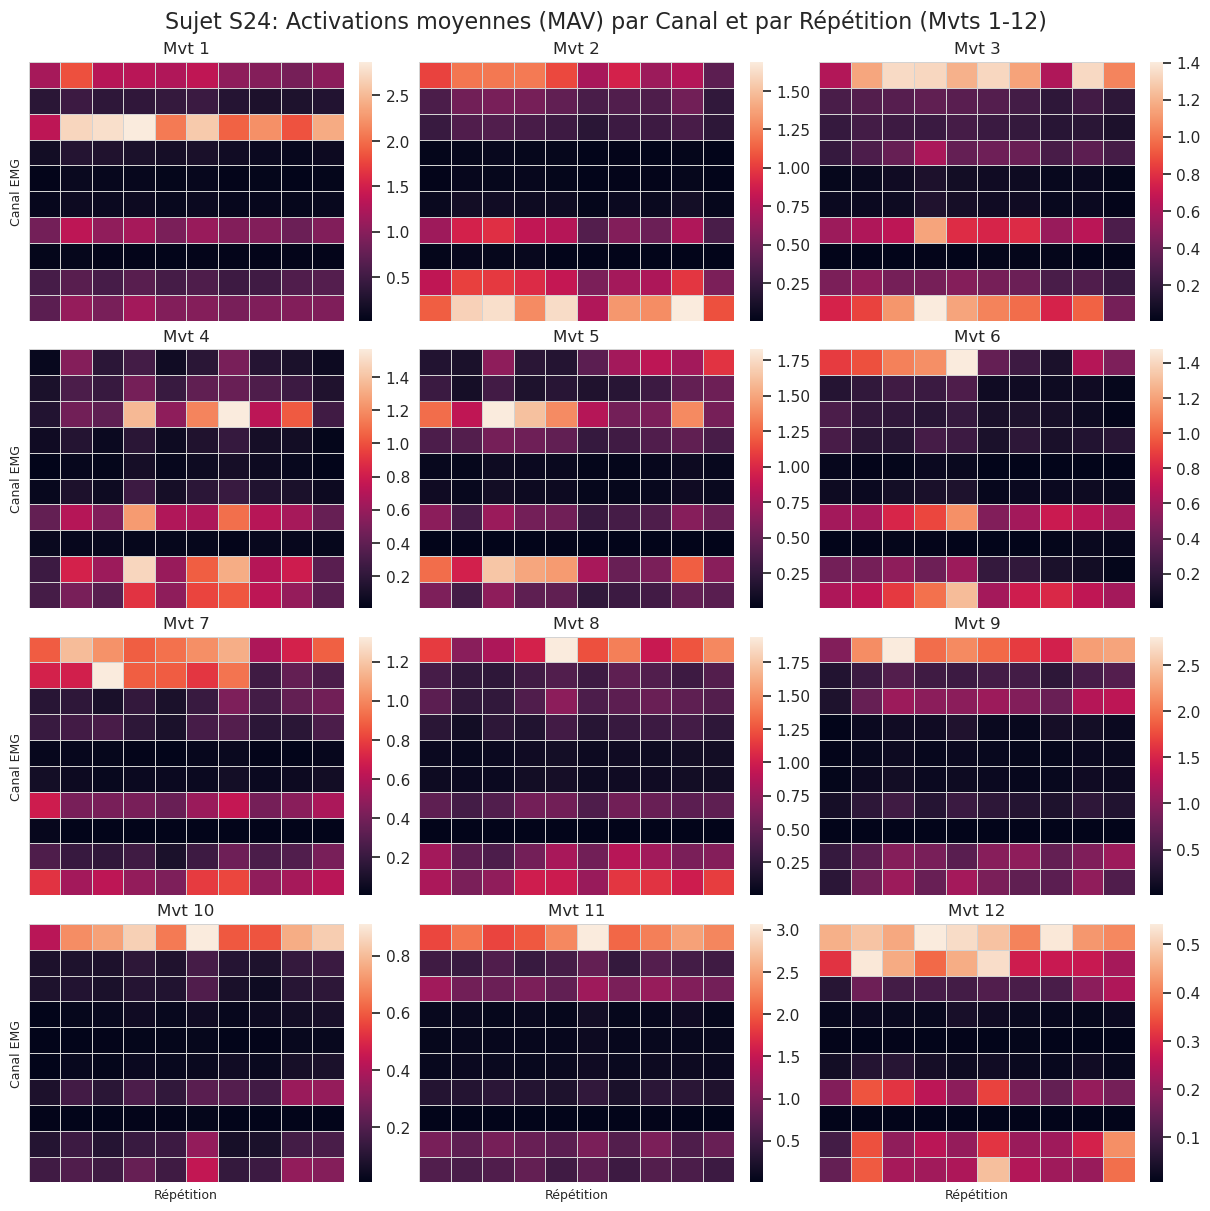

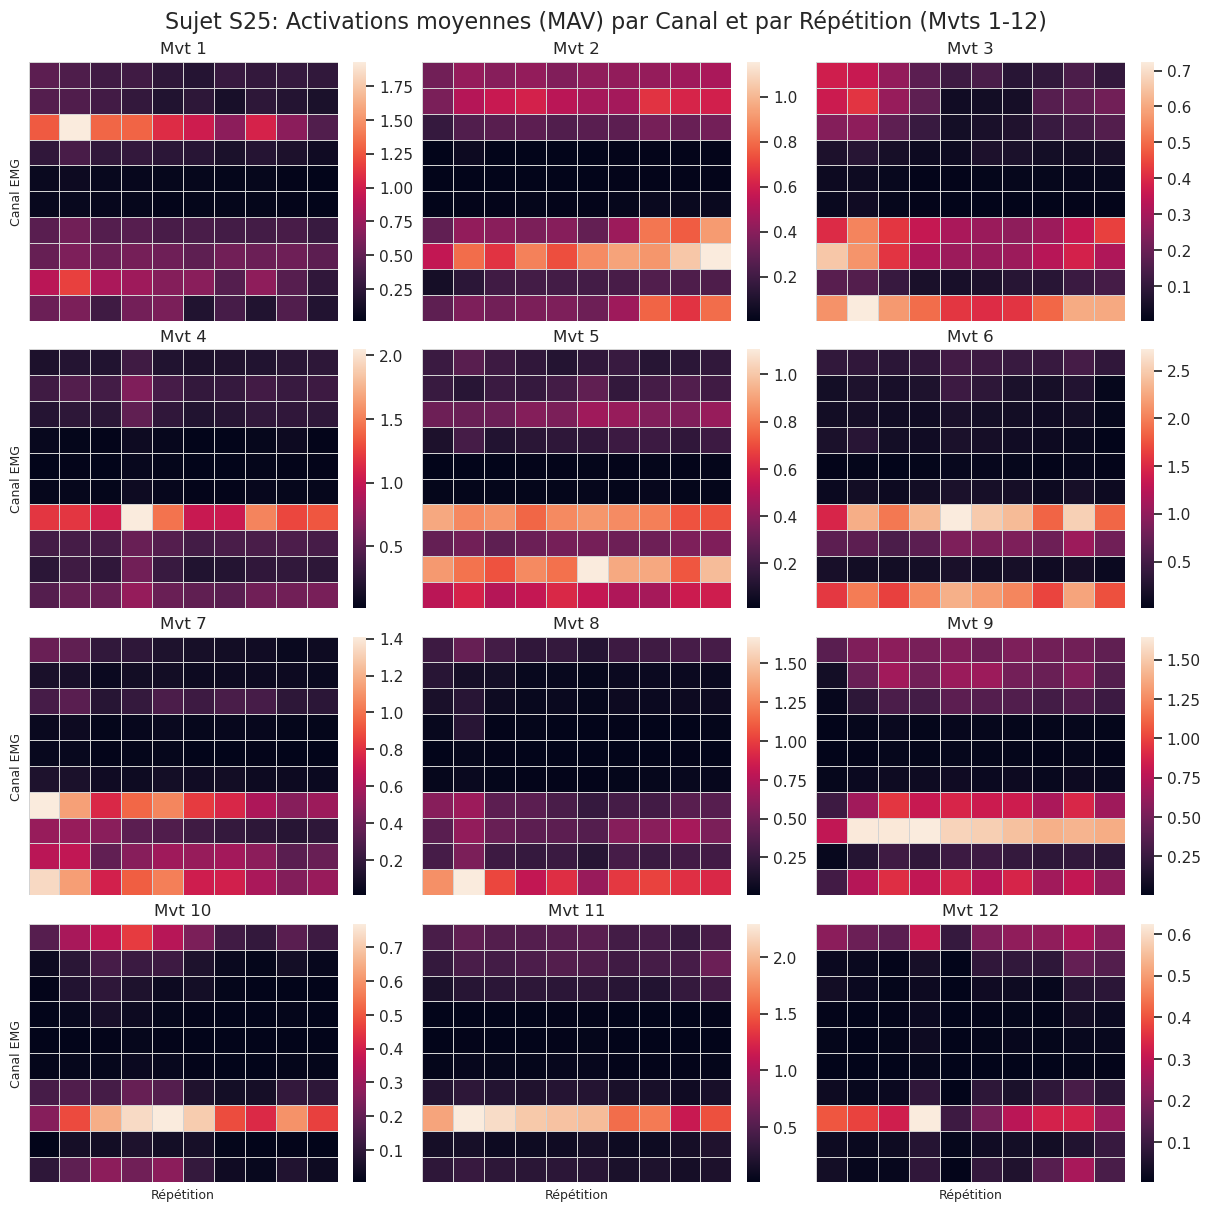

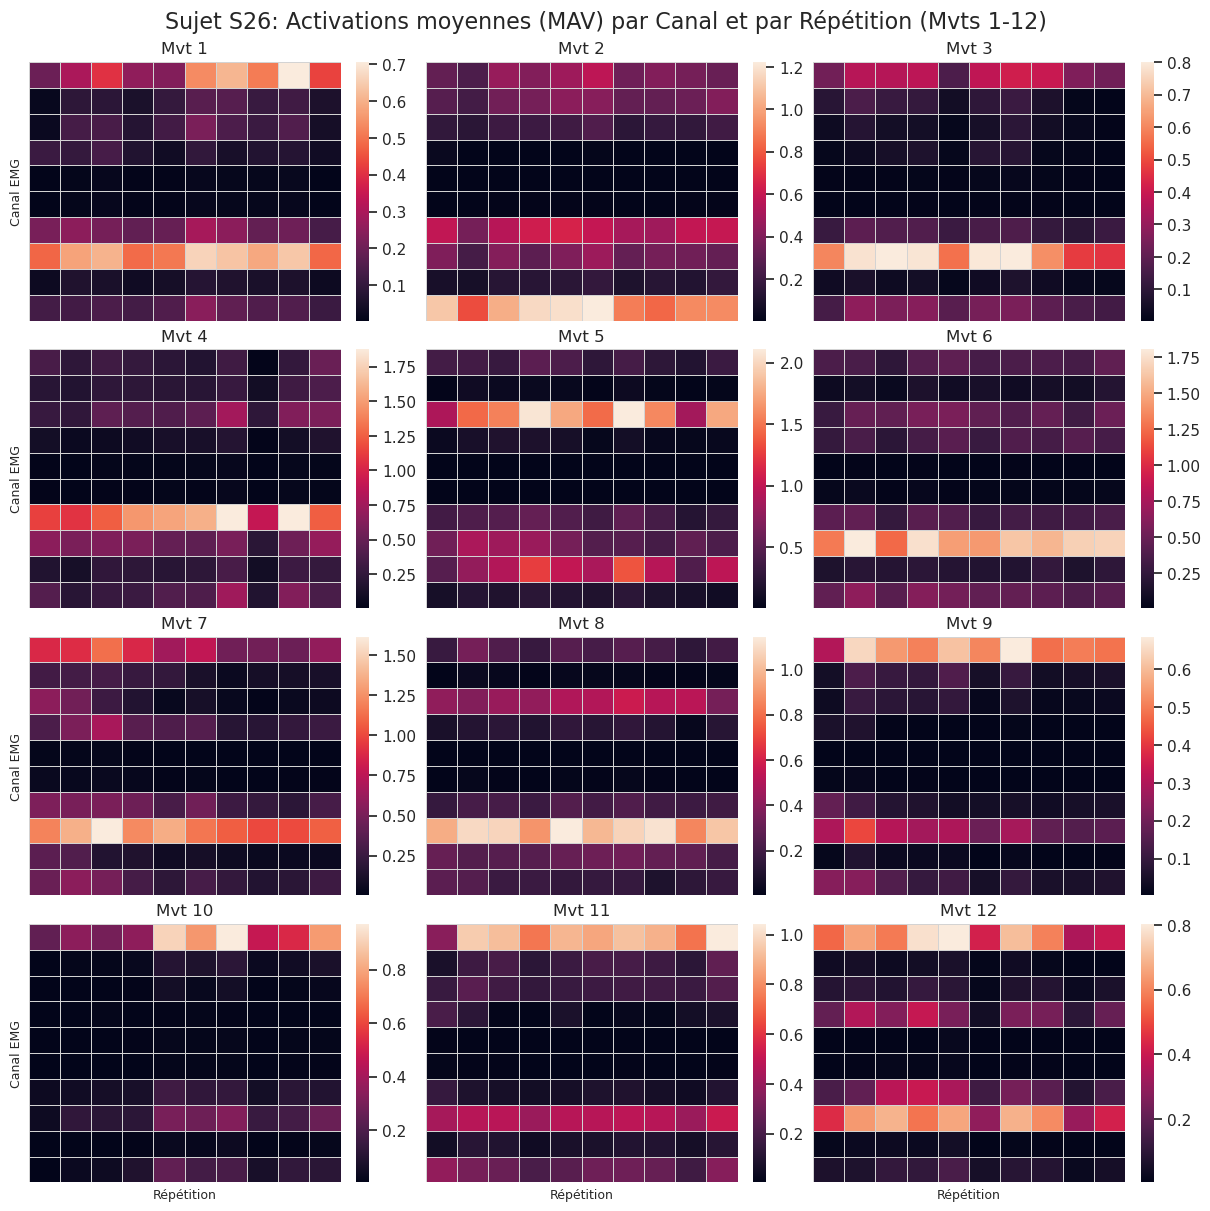

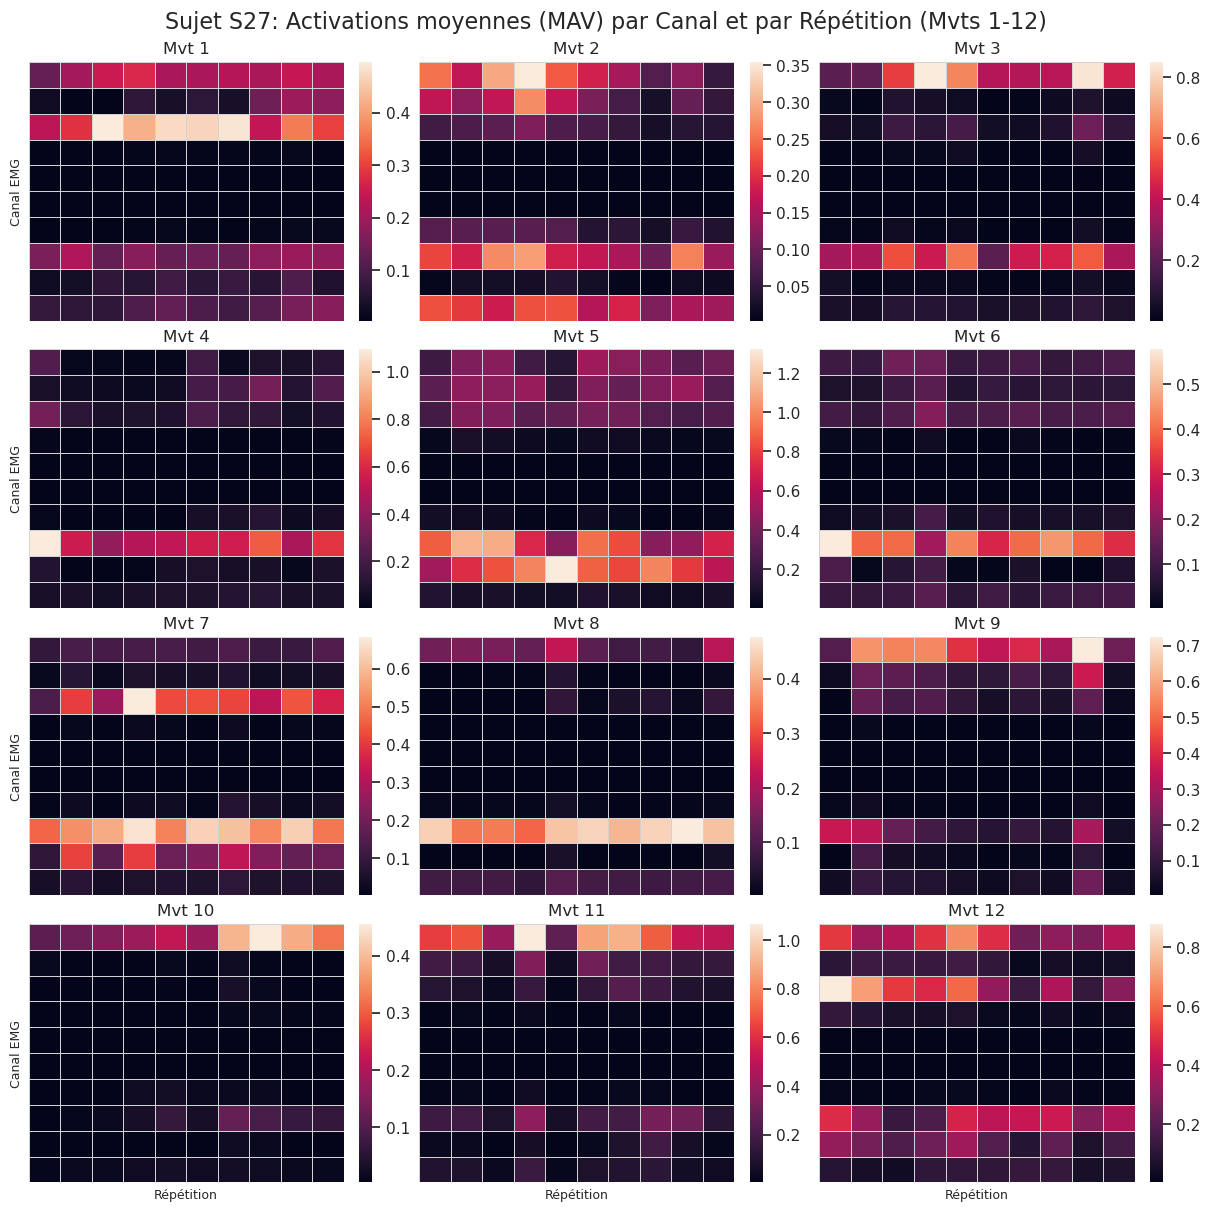

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Assurez-vous que seaborn est importé
from scipy.ndimage import convolve1d # S'assurer que convolve1d est disponible si vous n'avez pas relancé les blocs précédents

# Constantes Ninapro DB1 A1
N_CHANNELS = 10
N_STIMULI = 12
N_REPETITIONS = 10

# --- Boucle pour visualiser les activations moyennes par répétition pour tous les sujets ---
for subject in all_processed.keys():
    
    # 1. Récupération des données d'enveloppe
    if "emg_envelopes" not in all_processed[subject]:
        print(f"⚠️ Erreur: Les enveloppes EMG n'ont pas été calculées pour le sujet {subject}. Veuillez lancer l'étape 2 du bloc précédent.")
        continue

    emg_envelopes = all_processed[subject]["emg_envelopes"]
    
    # Initialiser le tableau pour stocker les moyennes d'activation
    # Shape: (10 canaux, 53 stimuli, 6 répétitions)
    emg_average_activations = np.zeros((N_CHANNELS, N_STIMULI, N_REPETITIONS))

    # 2. Calcul de l'activation moyenne
    # C'est l'équivalent du MAV (Mean Absolute Value) calculé sur l'enveloppe
    for stimuli_idx in range(N_STIMULI):
        for repetition_idx in range(N_REPETITIONS):
            window = emg_envelopes[stimuli_idx][repetition_idx]
            
            if window is not None and window.size > 0:
                # Calcul de la moyenne temporelle pour chaque canal (axis=0)
                # Stockage dans le tableau : [Canaux, Mouvement, Répétition]
                emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(window, axis=0)
            else:
                # Si la fenêtre est vide, l'activation reste 0
                emg_average_activations[:, stimuli_idx, repetition_idx] = 0

    # 3. Visualisation des 12 premiers mouvements (pour un aperçu rapide)
    
    # Nous affichons seulement les 12 premiers mouvements (1-12) sur 4 lignes x 3 colonnes
    N_PLOTS_PER_FIGURE = 12
    
    fig, ax = plt.subplots(4, 3, figsize=(12, 12), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()
    
    for plot_idx in range(N_PLOTS_PER_FIGURE):
        if plot_idx >= N_STIMULI:
            break

        # Squeezing to get a 2D array: (Canaux, Répétitions) for the current stimulus
        data_to_plot = emg_average_activations[:, plot_idx, :]
        
        # Création de la heatmap
        sns.heatmap(
            data_to_plot, 
            ax=ax[plot_idx], 
            xticklabels=False, 
            yticklabels=False,
            cbar=True, 
            linewidths=0.5, linecolor='lightgray'
        )
        ax[plot_idx].title.set_text("Mvt " + str(plot_idx + 1))
        ax[plot_idx].tick_params(labelsize=8)
        
        # Labels uniquement sur la première colonne et dernière ligne pour éviter la surcharge
        if plot_idx % 3 == 0:
            ax[plot_idx].set_ylabel("Canal EMG", fontsize=9)
        if plot_idx >= 9:
            ax[plot_idx].set_xlabel("Répétition", fontsize=9)
        else:
            ax[plot_idx].set_xlabel("") # Supprimer le label des autres
    
    # Titre général pour la figure
    plt.suptitle(f"Sujet {subject}: Activations moyennes (MAV) par Canal et par Répétition (Mvts 1-12)", fontsize=16)
    plt.show()

#

## 2) Split data and extract features

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Définition des Caractéristiques (Features)
# Toutes les fonctions doivent prendre un array (fenêtre EMG) de shape (Timepoints, Channels)
# et retourner un array de shape (Channels,)

# Mean Absolute Value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0) 
# Maximum Absolute Value (MaxAV) - Peak Value
maxav = lambda x: np.max(np.abs(x), axis=0) 
# Root Mean Square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform Length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope Sign Changes (SSC) - Compte le nombre de fois où la pente change de signe (seulement > 0)
ssc = lambda x: np.sum(((x[1:-1] - x[:-2]) * (x[1:-1] - x[2:]) > 0), axis=0)
# Zero Crossings (ZC) - Compte le nombre de fois où le signal traverse zéro
zc = lambda x: np.sum((x[:-1] * x[1:] < 0), axis=0)

FEATURE_SET = [mav, std, maxav, rms, wl, ssc, zc] 
FEATURE_NAMES = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC", "ZC"]

def build_dataset_from_ninapro(emg, stimulus, repetition, features):

    n_stimuli_all = np.unique(stimulus).size 
    
    n_stimuli = n_stimuli_all - 1
    
    n_repetitions = np.unique(repetition).size - 1
    
    # Correction: Si 'stimulus' ne contient que des valeurs > 0 (comme pour restimulus), 
    # n_stimuli = np.unique(stimulus).size. Mais assumons la structure avec 0 (repos).
    
    n_samples = n_stimuli * n_repetitions
    n_channels = emg.shape[1]
    n_features_total = sum(n_channels for feature in features)
    
    dataset = np.zeros((n_samples, n_features_total))
    # Nous stockons les labels du mouvement (1 à 12)
    labels = np.zeros(n_samples) 
    
    current_sample_index = 0
    
    for i in range(n_stimuli): 
        current_stimulus_id = i + 1 # Stimulus va de 1 à 12
        
        for j in range(n_repetitions):
            current_repetition_id = j + 1 # Répétition va de 1 à 10
            
            selected_tsteps = np.logical_and(stimulus == current_stimulus_id, repetition == current_repetition_id).squeeze()
            
            # Nous devons vérifier si la fenêtre contient des données (si la durée > 0)
            window_data = emg[selected_tsteps, :]
            
            if window_data.shape[0] > 0:
                # 1. Assignation du Label
                labels[current_sample_index] = current_stimulus_id 
                
                current_feature_index = 0
                # 2. Extraction des Caractéristiques
                for feature in features:
                    selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                    
                    # Calculer et stocker la caractéristique
                    dataset[current_sample_index, selected_features] = feature(window_data)
                    
                    current_feature_index += n_channels
                    
                # 3. Passer à l'échantillon suivant
                current_sample_index += 1

    # Redimensionner les tableaux au nombre réel d'échantillons (au cas où certaines fenêtres étaient vides)
    dataset = dataset[:current_sample_index, :]
    labels = labels[:current_sample_index]
    
    return dataset, labels

In [22]:
# Listes pour agréger les jeux de données de tous les sujets
all_datasets = []
all_labels = []
all_subject_ids = []

print("--- Extraction des caractéristiques par Sujet ---")

for subject_id, data in all_processed.items():
    emg = data["emg"]
    stimulus = data["stimulus"]
    repetition = data["repetition"]
    
    # Construire le dataset pour le sujet courant
    dataset_sub, labels_sub = build_dataset_from_ninapro(
        emg=emg,
        stimulus=stimulus,
        repetition=repetition,
        features=FEATURE_SET
    )
    
    if dataset_sub.shape[0] > 0:
        all_datasets.append(dataset_sub)
        all_labels.append(labels_sub)
        
        # Créer un array pour identifier le sujet de chaque échantillon
        subject_id_array = np.full(dataset_sub.shape[0], int(subject_id.replace('S', '')))
        all_subject_ids.append(subject_id_array)
        
        print(f"Sujet {subject_id}: {dataset_sub.shape[0]} échantillons extraits.")
    else:
        print(f"Sujet {subject_id}: 0 échantillons valides (Skippé).")

# Agrégation finale de toutes les données
X_full = np.concatenate(all_datasets, axis=0)
y_full = np.concatenate(all_labels, axis=0)
Z_subject = np.concatenate(all_subject_ids, axis=0) # Z_subject contient l'ID du sujet pour chaque échantillon

print(f"\n--- Jeu de données agrégé ---")
print(f"X_full (Total Caractéristiques): {X_full.shape}")
print(f"y_full (Total Étiquettes): {y_full.shape}")
print(f"Z_subject (Total IDs Sujet): {Z_subject.shape}")
print("-" * 40)

--- Extraction des caractéristiques par Sujet ---
Sujet S2: 120 échantillons extraits.
Sujet S1: 120 échantillons extraits.
Sujet S3: 120 échantillons extraits.
Sujet S4: 120 échantillons extraits.
Sujet S5: 120 échantillons extraits.
Sujet S6: 120 échantillons extraits.
Sujet S7: 120 échantillons extraits.
Sujet S8: 120 échantillons extraits.
Sujet S9: 120 échantillons extraits.
Sujet S10: 120 échantillons extraits.
Sujet S11: 120 échantillons extraits.
Sujet S12: 120 échantillons extraits.
Sujet S13: 120 échantillons extraits.
Sujet S14: 120 échantillons extraits.
Sujet S15: 120 échantillons extraits.
Sujet S16: 120 échantillons extraits.
Sujet S17: 120 échantillons extraits.
Sujet S18: 120 échantillons extraits.
Sujet S19: 120 échantillons extraits.
Sujet S20: 120 échantillons extraits.
Sujet S21: 120 échantillons extraits.
Sujet S22: 120 échantillons extraits.
Sujet S23: 120 échantillons extraits.
Sujet S24: 120 échantillons extraits.
Sujet S25: 120 échantillons extraits.
Sujet S26

In [23]:
# Séparation des données : 70% Train, 15% Validation, 15% Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, 
    y_full, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_full # Stratification basée sur les labels de mouvement
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_temp # Stratification basée sur les labels restants
)

print("\n--- Dimensions des jeux de données ---")
print(f"Train Set: {X_train.shape[0]} échantillons")
print(f"Validation Set: {X_val.shape[0]} échantillons")
print(f"Test Set: {X_test.shape[0]} échantillons")


--- Dimensions des jeux de données ---
Train Set: 2268 échantillons
Validation Set: 486 échantillons
Test Set: 486 échantillons


In [24]:
from sklearn.preprocessing import StandardScaler

# 1. Initialiser le scaler
scaler = StandardScaler()

# 2. Entraîner le scaler UNIQUEMENT sur l'ensemble d'entraînement
X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Normalisation terminée. Les données sont prêtes pour l'entraînement.")

Normalisation terminée. Les données sont prêtes pour l'entraînement.


In [25]:
from sklearn.ensemble import RandomForestClassifier

# Modèle Baseline (avec les paramètres par défaut)
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train_scaled, y_train)

# Évaluation sur l'ensemble de validation
baseline_acc = rf_baseline.score(X_val_scaled, y_val)
print(f"Accuracy du modèle Baseline (Validation) : {baseline_acc:.4f}")

Accuracy du modèle Baseline (Validation) : 0.8210


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

param_grid = {
    "n_estimators":  [400, 600, 800],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [1, 2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf_opt = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    estimator=rf_opt,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross validation
    scoring="accuracy",   # optimiser l'accuracy
    n_jobs=-1,            # utiliser tous les cœurs
    verbose=1
)

print("\n--- Début de l'optimisation des hyperparamètres (Grid Search) ---")
start_time = time.time()

# Entraînement de la Grid Search
grid.fit(X_train_scaled, y_train)

end_time = time.time()
print(f"Temps d'exécution de la Grid Search : {end_time - start_time:.2f} secondes")

print("\nMeilleurs paramètres trouvés :", grid.best_params_)
print(f"Meilleure Accuracy CV (sur Train) : {grid.best_score_:.4f}")

# Récupérer le meilleur modèle
best_rf = grid.best_estimator_

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# Évaluation sur Validation et Test (données normalisées)
val_acc = best_rf.score(X_val_scaled, y_val)
test_acc = best_rf.score(X_test_scaled, y_test)

print("-" * 50)
print(f"Accuracy sur l'ensemble de Validation : {val_acc:.4f}")
print(f"Accuracy sur l'ensemble de Test : {test_acc:.4f}")

# Métriques détaillées sur l'ensemble de Test
y_pred_test = best_rf.predict(X_test_scaled)

print("\n--- Métriques de performance sur l'ensemble de Test ---")
print(f"Accuracy : {accuracy_score(y_test, y_pred_test):.4f}")
# Le F1-score macro est une bonne métrique pour les problèmes multi-classes comme celui-ci, 
# car il traite toutes les classes avec le même poids, corrigeant les déséquilibres potentiels.
print(f"Macro F1-score : {f1_score(y_test, y_pred_test, average='macro'):.4f}")
